# 데이터 불러오기

In [ ]:
# 한글폰트 사용 in colab
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (7,581 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122349 files and di

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family="NanumBarunGothic")

In [ ]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt

sns.set_palette("bright")
sns.set_style('darkgrid')

In [ ]:
demo = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_01_DEMO.csv")
pdde = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_02_PDDE.csv")
cop = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_03_COP_U.csv")
pd_clac = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_04_PD_CLAC.csv")
br = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_05_BR.csv")
lpay = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_06_LPAY.csv")
# 외부 변수
holiday = pd.read_csv("/content/mnt/MyDrive/LDA/data/holiday.csv")

<ipython-input-4-6d2d495ff88d>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pdde = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_02_PDDE.csv")


## `Interaction` 데이터
- `pdde`,`cop`,`lpay` 에 기록된 모든 거래
- `demo`,`pdde`,`cop`,`pd_clac`,`br`,`lpay` 병합
- 자세한 병합 과정 : `5.TABLE_MERGE.ipynb` 참조

In [ ]:
interaction=pd.read_csv('/content/mnt/MyDrive/LDA/data/interaction.csv')

<ipython-input-5-e36d43b27c7c>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interaction=pd.read_csv('/content/mnt/MyDrive/LDA/data/interaction.csv')


# 도구 함수

In [ ]:
def get_season(x):
  x = int(x)
  if 3 <= x < 6:
    return 0
  elif 6 <= x < 9:
    return 1
  elif 9 <= x <12:
    return 2
  else:
    return 3

def make_time_feats(df):
  """
  시간 변수를 생성
  """
  df['de_dt'] = df['de_dt'].astype("str")
  df["de_dt"] = pd.to_datetime(df['de_dt'])
  df['de_dow'] = df['de_dt'].dt.dayofweek
  df['de_day'] = df['de_dt'].dt.day
  df['de_month'] = df['de_dt'].dt.month.apply(lambda x : f"{x:0>2}") # zero-pad
  df["de_day"] = df['de_dt'].dt.day.apply(lambda x : f"{x:0>2}") # zero-pad
  df["de_hr"] = df["de_hr"].apply(lambda x : f"{x:0>2}") # zero-pad
  df['de_hday'] = df['de_dow'].apply(lambda x : 1 if x == 5 or x == 6 else 0)
  df['de_season'] = df['de_month'].apply(lambda x : get_season(x))

  hday = set(holiday['날짜'].unique())
  df.loc[df.de_dt.isin(hday), "de_hday"] = 1

In [ ]:
def pie_chart(data, cat, figsize):
  """
  파이 차트를 그립니다.
  args
    - data : pd.DataFrame
    - cat : 카테고리 이름
    - figsize : figsize
  """
  fig, axs = plt.subplots(figsize = figsize)
  pie_idx, pie_value = data[cat].value_counts().index, data[cat].value_counts().values
  axs.pie(pie_value, labels = pie_idx, autopct = "%.1f")
  plt.title(f"{cat}")
  plt.show()

In [ ]:
def get_log(x):

  '''
  log column 생성
  - 가격 리스트 입력
  - log 가격 리스트 반환
  '''

  price_list=[]
  for i in x:
    price=np.log1p(i)
    price_list.append(price)
  return price_list

In [ ]:
make_time_feats(pdde)
make_time_feats(cop)
make_time_feats(lpay)
make_time_feats(interaction)

In [ ]:
demo['ma_fem_dv_ages'] = demo['ma_fem_dv'] + demo['ages']
interaction['ma_fem_dv_ages'] = interaction['ma_fem_dv'] + interaction['ages']

# 1. *Interaction*

## A. 데이터 확인

In [ ]:
interaction.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,zon_mcls,pd_nm,clac_mcls_nm,clac_hlv_nm,de_dow,de_day,de_month,de_hday,de_season,ma_fem_dv_ages
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1.0,...,Z10042,남성티셔츠,남성의류상의,남성의류,4,01,01,1,3,여성50대
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1.0,...,Z13001,기타주방일회용품,주방일회용품,주방잡화,4,01,01,1,3,여성40대
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1.0,...,Z10042,남성티셔츠,남성의류상의,남성의류,4,01,01,1,3,여성50대
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1.0,...,Z10042,남성티셔츠,남성의류상의,남성의류,4,01,01,1,3,여성50대
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1.0,...,Z10042,남성티셔츠,남성의류상의,남성의류,4,01,01,1,3,여성50대


In [ ]:
interaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983231 entries, 0 to 4983230
Data columns (total 26 columns):
 #   Column          Dtype         
---  ------          -----         
 0   cust            object        
 1   rct_no          object        
 2   chnl_dv         int64         
 3   cop_c           object        
 4   br_c            object        
 5   pd_c            object        
 6   de_dt           datetime64[ns]
 7   de_hr           object        
 8   buy_am          float64       
 9   buy_ct          float64       
 10  deal_type       int64         
 11  vst_dt          float64       
 12  ma_fem_dv       object        
 13  ages            object        
 14  zon_hlv_user    object        
 15  zon_hlv         object        
 16  zon_mcls        object        
 17  pd_nm           object        
 18  clac_mcls_nm    object        
 19  clac_hlv_nm     object        
 20  de_dow          int64         
 21  de_day          object        
 22  de_month        ob

#### 원소 개수 확인

In [ ]:
interaction.nunique()

cust                29874
rct_no            1868077
chnl_dv                 2
cop_c                  14
br_c                 8785
pd_c                 1947
de_dt                 369
de_hr                  24
buy_am              59453
buy_ct                 85
deal_type               3
vst_dt                366
ma_fem_dv               2
ages                    6
zon_hlv_user           17
zon_hlv                19
zon_mcls              259
pd_nm                1946
clac_mcls_nm          361
clac_hlv_nm            63
de_dow                  7
de_day                 31
de_month               12
de_hday                 2
de_season               4
ma_fem_dv_ages         12
dtype: int64

In [ ]:
interaction[['buy_am','buy_ct']].describe()

,buy_am,buy_ct
count,4.983231e+06,4.983231e+06
mean,2.572380e+04,1.272899e+00
std,2.403203e+05,1.500124e+00
min,1.000000e+00,1.000000e+00
25%,2.290000e+03,1.000000e+00
50%,4.600000e+03,1.000000e+00
75%,1.050000e+04,1.000000e+00
max,7.009200e+07,1.000000e+02


### 결측치 확인
- 제휴사 거래 중 `de_dt`와 `vst_dt`가 다른 거래 존재

In [ ]:
interaction.isnull().sum()

cust                    0
rct_no                  0
chnl_dv                 0
cop_c                   0
br_c                    0
pd_c                    0
de_dt                   0
de_hr                   0
buy_am                  0
buy_ct                  0
deal_type               0
vst_dt            4734927
ma_fem_dv               0
ages                    0
zon_hlv_user            0
zon_hlv                 0
zon_mcls                0
pd_nm                   0
clac_mcls_nm            0
clac_hlv_nm             0
de_dow                  0
de_day                  0
de_month                0
de_hday                 0
de_season               0
ma_fem_dv_ages          0
dtype: int64

## B. Basic

#### 1) 거래 타입 별 비율
`'deal_type'`: 유통사, 제휴사, 엘페이 거래 여부 
- pdde : 0
- cop : 1
- lpay : 2

전체 데이터 개수 : 4983231
유통사 데이터 개수 : 4381743
제휴사 데이터 개수 : 248304
엘페이 데이터 개수 : 353184


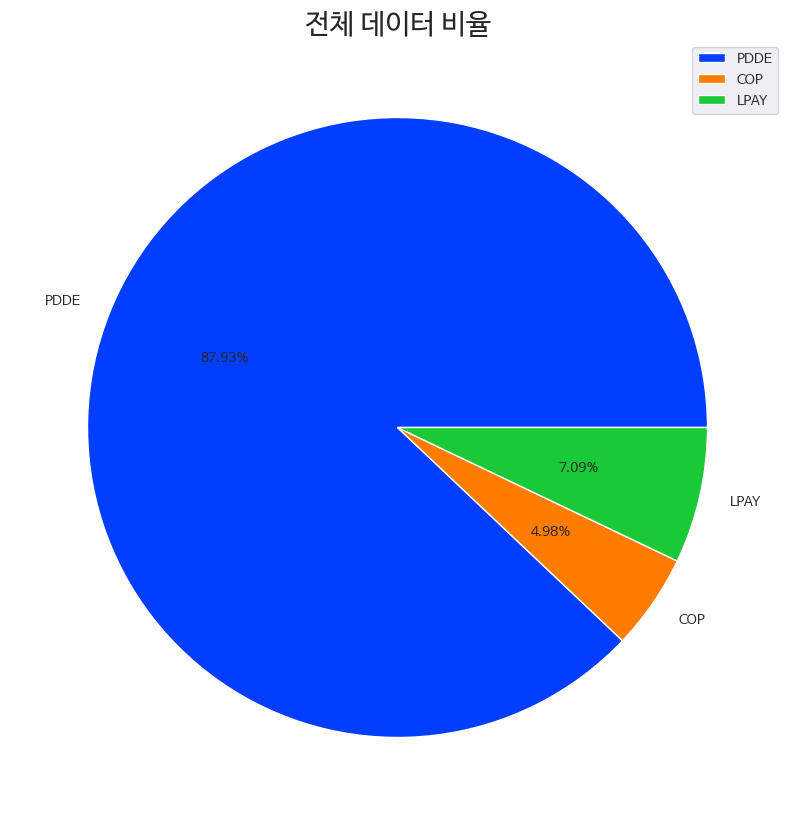

In [ ]:
print(f'전체 데이터 개수 : {len(interaction)}')
print(f'유통사 데이터 개수 : {len(interaction.loc[interaction.deal_type==0])}')
print(f'제휴사 데이터 개수 : {len(interaction.loc[interaction.deal_type==1])}')
print(f'엘페이 데이터 개수 : {len(interaction.loc[interaction.deal_type==2])}')

cnt = [len(interaction.loc[interaction.deal_type==0]), len(interaction.loc[interaction.deal_type==1]),len(interaction.loc[interaction.deal_type==2])]
labels= ["PDDE", "COP", "LPAY"]
fig, axs = plt.subplots(figsize = (10, 15))
axs.set_title("전체 데이터 비율",fontsize=20)
axs.pie(x = cnt, labels = labels, autopct = '%.2f%%')
axs.legend()

### 2) 거래 고객 확인

#### 거래 유무

전체 고객 수 : 29913
거래 있는 고객 수 : 29874
거래 없는 고객 수 : 39


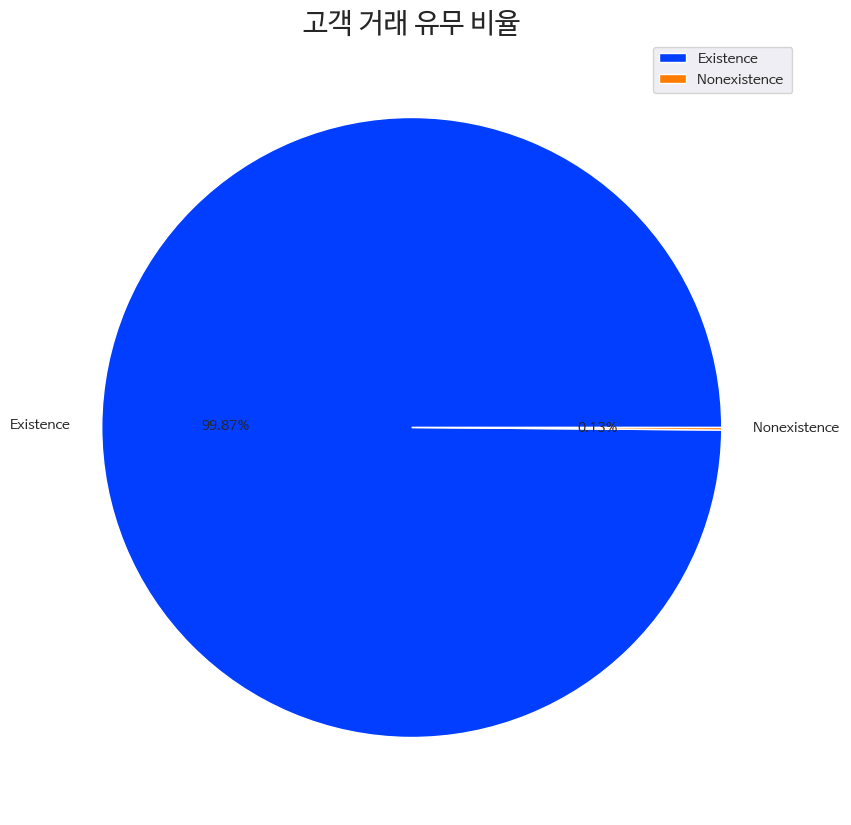

In [ ]:
print(f'전체 고객 수 : {demo.cust.nunique()}')
print(f'거래 있는 고객 수 : {interaction.cust.nunique()}')
print(f'거래 없는 고객 수 : {demo.cust.nunique()-interaction.cust.nunique()}')

cnt = [interaction.cust.nunique(),(demo.cust.nunique()-interaction.cust.nunique())]
labels= ["Existence", "Nonexistence "]
fig, axs = plt.subplots(figsize = (10, 15))
axs.set_title("고객 거래 유무 비율",fontsize=20)
axs.pie(x = cnt, labels = labels, autopct = '%.2f%%')
axs.legend()

#### 성별

여성 고객 수 : 20072
남성 고객 수 : 9802


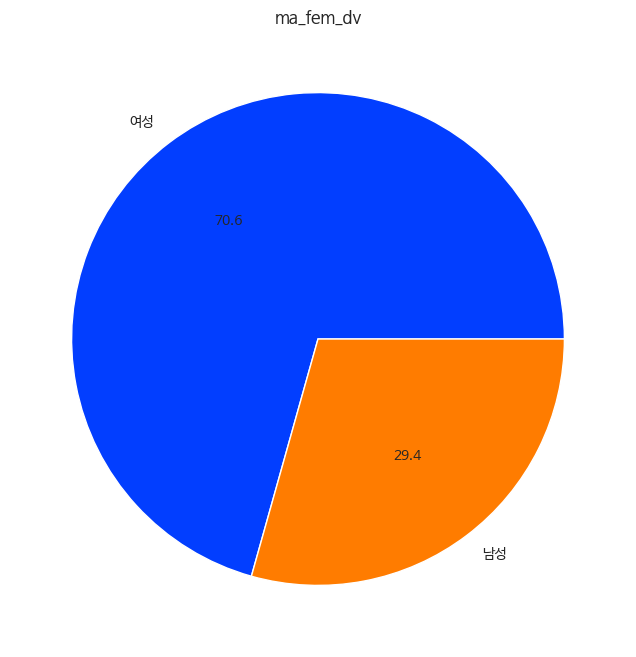

In [ ]:
print(f'여성 고객 수 : {interaction.loc[interaction.ma_fem_dv=="여성"].cust.nunique()}')
print(f'남성 고객 수 : {interaction.loc[interaction.ma_fem_dv=="남성"].cust.nunique()}')

pie_chart(interaction, "ma_fem_dv",(8, 8))

#### 연령별

20대 고객 수 : 3849
30대 고객 수 : 7733
40대 고객 수 : 9862
50대 고객 수 : 5633
60대 고객 수 : 2104
70대 고객 수 : 693


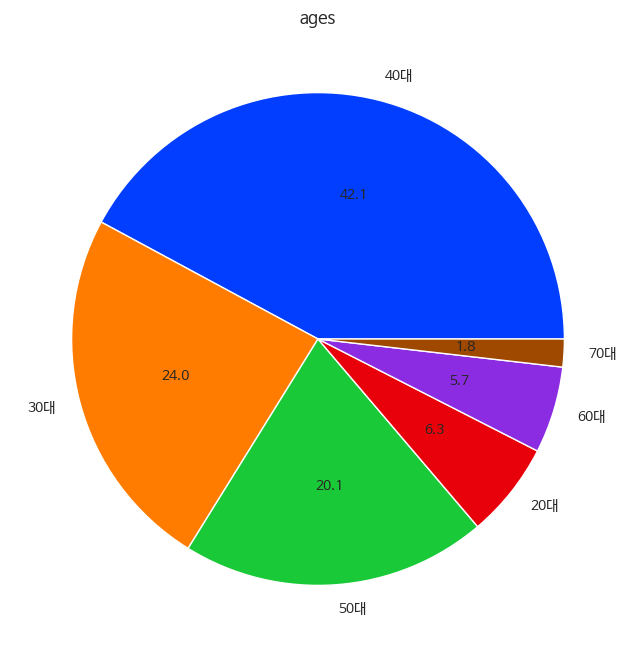

In [ ]:
for i in range(2,8):
  age=str(i) +'0대'
  print(f'{age} 고객 수 : {interaction.loc[interaction.ages==age].cust.nunique()}')

pie_chart(interaction, "ages",(8, 8))

#### 성별/연령별

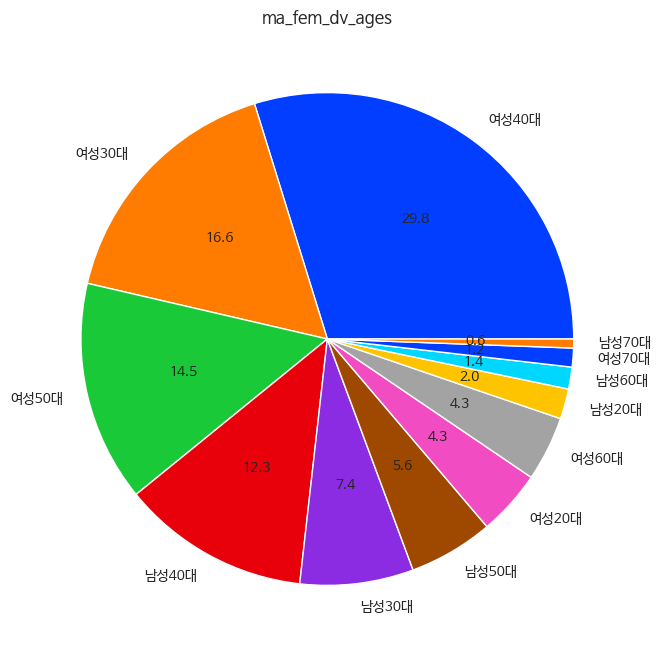

In [ ]:
pie_chart(interaction, "ma_fem_dv_ages",(8, 8))

#### 유통사/제휴사/엘페이 구분별
- `제휴사(COP)와 엘페이(LPAY)`는 거래 횟수는 적지만(`4.98%`, `6.09%` 차지), 구매 고객 자체는 적지 않은편 

<Axes: xlabel='deal_type', ylabel='cust'>

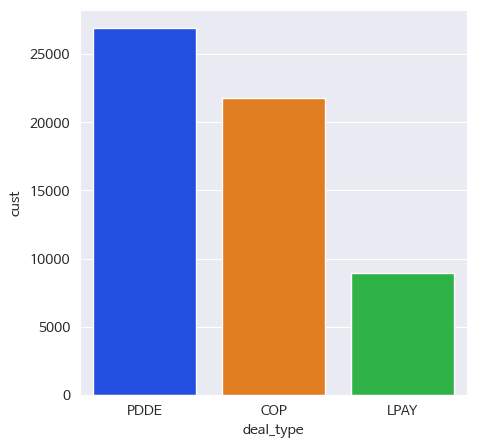

In [ ]:
fig, axs = plt.subplots(figsize = (5, 5))
temp = interaction.groupby(["deal_type"])['cust'].nunique().reset_index()
temp['deal_type']=['PDDE','COP','LPAY']
sns.barplot(data = temp, x = "deal_type", y = "cust")

### 3) 거래 횟수 별 양상 확인

#### 고객 위치 지역별 거래 횟수


<Axes: xlabel='zon_hlv_user', ylabel='rct_no'>

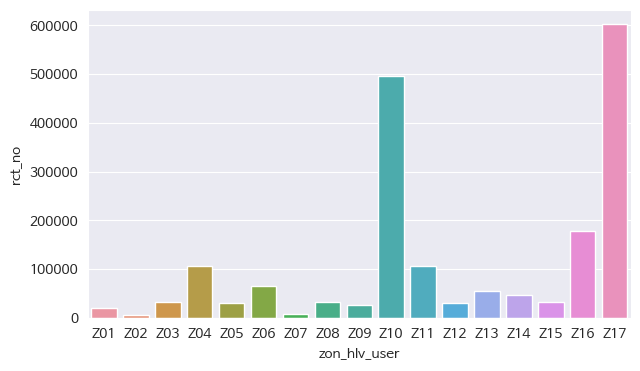

In [ ]:
fig, axs = plt.subplots(figsize=(7,4))
temp=interaction.groupby(['zon_hlv_user']).rct_no.nunique().reset_index()
sns.barplot(data = temp, x = "zon_hlv_user",y='rct_no')

#### 판매처 지역별 유통사, 제휴사, LPAY 거래 정보

<Axes: xlabel='zon_hlv', ylabel='rct_no'>

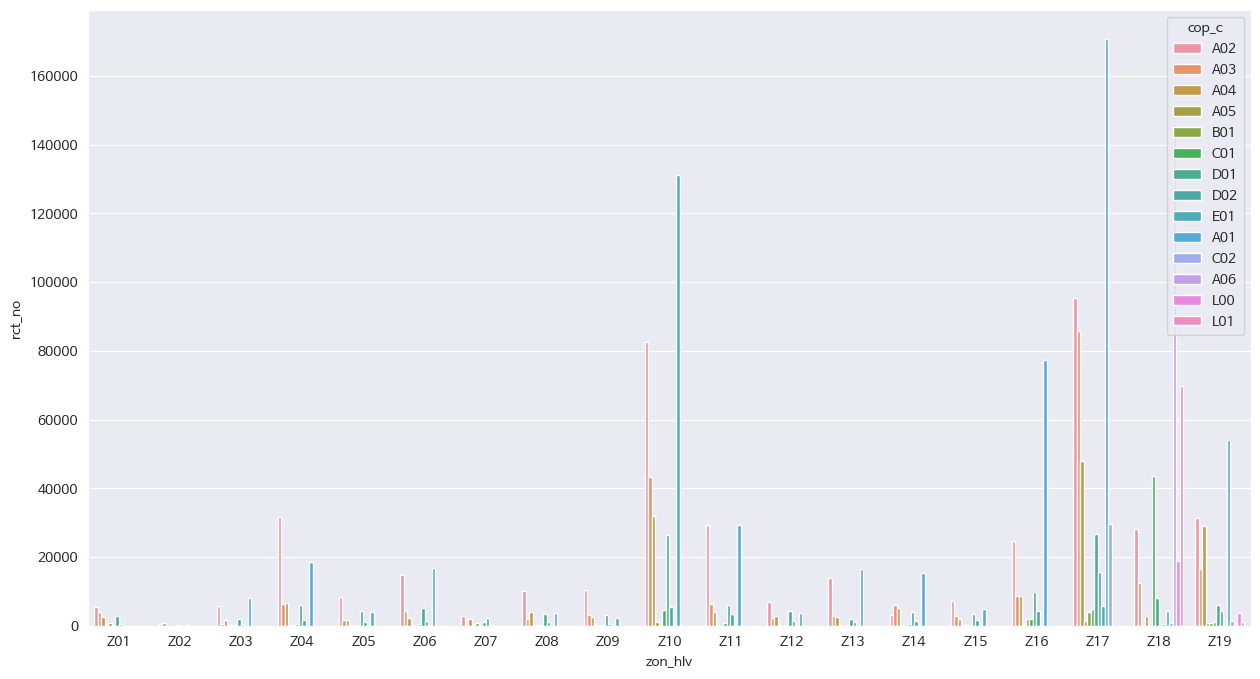

In [ ]:
fig, axs = plt.subplots(figsize=(15,8))
temp=interaction.groupby(['zon_hlv','cop_c']).rct_no.nunique().reset_index()
sns.barplot(data = temp, x = "zon_hlv",y='rct_no', hue = "cop_c")

#### 유통사/제휴사/엘페이 온/오프라인 별 거래 횟수
- `LPAY` 거래를 제외하곤, 오프라인 거래(`chnl_dv = 1`)가 훨씬 많음

<Axes: xlabel='deal_type', ylabel='rct_no'>

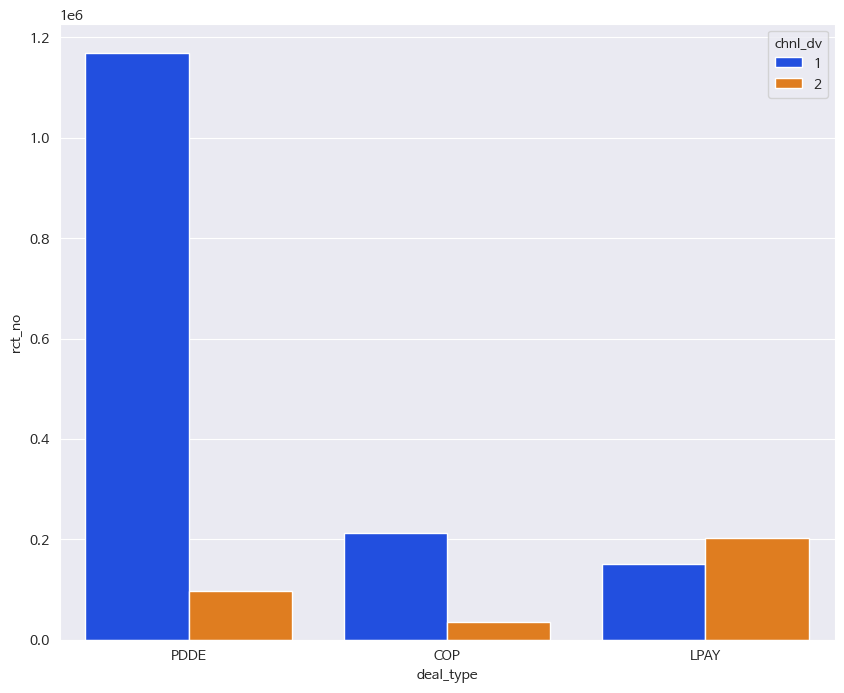

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
temp=interaction.groupby(['deal_type','chnl_dv']).rct_no.nunique().reset_index()
temp['deal_type']=['PDDE','PDDE','COP','COP','LPAY','LPAY']
sns.barplot(data = temp, x = "deal_type",y='rct_no', hue = "chnl_dv")

### 4) 점포 수 양상 확인 

#### 판매처 지역별

<Axes: xlabel='zon_hlv', ylabel='br_c'>

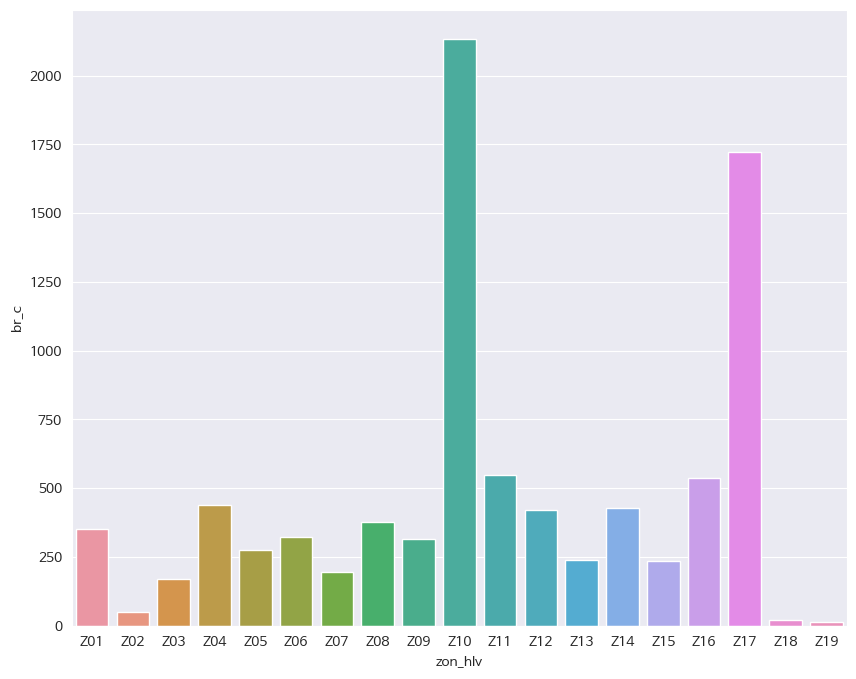

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
temp=interaction.groupby(['zon_hlv']).br_c.nunique().reset_index()
sns.barplot(data = temp, x = "zon_hlv",y='br_c')

#### 유통사/제휴사/LPAY 점포 수 확인
- LPAY는 정확한 점포 위치를 알 수 없다.

<Axes: xlabel='deal_type', ylabel='br_c'>

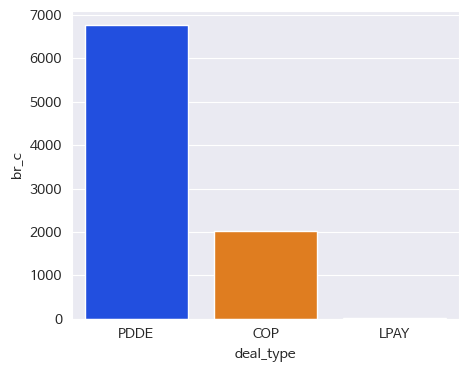

In [ ]:
fig, axs = plt.subplots(figsize=(5,4))
temp=interaction.groupby(['deal_type']).br_c.nunique().reset_index()
temp['deal_type']=['PDDE','COP','LPAY']
sns.barplot(data = temp, x = "deal_type",y='br_c')

## C. 카테고리 내 상대적 가격(Z-score 정보) 기준
- 카테고리별로 `상대적 가격`을 구해서 파악
  - 카테고리마다 다른 지출 성향 파악 가능

In [ ]:
interaction.sort_values(by = "pd_c", inplace = True)
temp = interaction.groupby("pd_c")["buy_am"].apply(list)
temp = temp.reset_index()
temp

,pd_c,buy_am
0,PD0001,"[53900.0, 500000.0, 250000.0, 1067000.0, 62421..."
1,PD0002,"[7900.0, 49000.0, 24900.0, 200000.0, 7900.0, 1..."
2,PD0003,"[680000.0, 17900.0, 79900.0, 680000.0, 680000...."
3,PD0004,"[18900.0, 121920.0, 430000.0, 39920.0, 18900.0..."
4,PD0005,"[150000.0, 176000.0, 528000.0, 1045000.0, 1200..."
...,...,...
1942,PD1943,"[74160.0, 104000.0, 7900.0, 42980.0, 35200.0, ..."
1943,PD1944,"[29170.0, 4490.0, 51950.0, 12980.0, 6530.0, 17..."
1944,PD1945,"[1890.0, 5760.0, 3150.0, 8280.0, 4500.0, 2000...."
1945,PD1946,"[196840.0, 46170.0, 61700.0, 164900.0, 952940...."


- 100원 딜, 대량 구매 등 편차 보정

In [ ]:
interaction['buy_am_log'] = interaction['buy_am'].apply(np.log1p)
temp = interaction.groupby("pd_c")["buy_am_log"].apply(list)
temp = temp.reset_index()
temp

,pd_c,buy_am_log
0,PD0001,"[10.894904309600681, 13.122365377402328, 12.42..."
1,PD0002,"[8.974744612722734, 10.799595985047786, 10.122..."
2,PD0003,"[13.429849547739444, 9.792611856190192, 11.288..."
3,PD0004,"[9.846970109700957, 11.711128572986574, 12.971..."
4,PD0005,"[11.918397239722838, 12.07824495582233, 13.176..."
...,...,...
1942,PD1943,"[11.213993684506969, 11.552155793461898, 8.974..."
1943,PD1944,"[10.280930344070526, 8.409830673087738, 10.858..."
1944,PD1945,"[7.544861068658458, 8.658866349732383, 8.05547..."
1945,PD1946,"[12.190151575235248, 10.740107174352467, 11.03..."


In [ ]:
from sklearn import preprocessing

def std_scaling(data):
  """
  Standardization

  args
    - data :   Standardization 원하는 데이터
  """
  data = np.array(data)
  print(data.shape)
  std_scaler = preprocessing.StandardScaler().fit(data.reshape(-1, 1))
  scaled_data = std_scaler.transform(data.reshape(-1, 1))
  scaled_data = list(map(lambda x : x[0], scaled_data))
  return scaled_data

In [ ]:
temp['buy_am_std']= temp['buy_am_log'].apply(std_scaling)

(313,)
(190,)
(99,)
(80,)
(642,)
(143,)
(170,)
(26,)
(52,)
(391,)
(495,)
(65,)
(63,)
(39,)
(7,)
(2,)
(31,)
(46,)
(11,)
(2,)
(19,)
(26,)
(39,)
(3,)
(648,)
(43,)
(171,)
(3,)
(10,)
(8,)
(3,)
(206,)
(503,)
(750,)
(1664,)
(262,)
(101,)
(132,)
(3,)
(2,)
(257,)
(505,)
(12,)
(647,)
(2206,)
(30,)
(380,)
(175,)
(11,)
(64,)
(1355,)
(36,)
(228,)
(3316,)
(4,)
(609,)
(758,)
(438,)
(8,)
(142,)
(170,)
(6,)
(26,)
(128,)
(6,)
(1,)
(430,)
(1269,)
(359,)
(23,)
(8,)
(86,)
(46,)
(52,)
(36,)
(25,)
(507,)
(47,)
(69,)
(1932,)
(324,)
(3621,)
(884,)
(258,)
(32,)
(64,)
(463,)
(59,)
(2075,)
(1881,)
(393,)
(350,)
(1209,)
(97,)
(4241,)
(2955,)
(2964,)
(3100,)
(918,)
(851,)
(126,)
(1601,)
(25,)
(202,)
(81,)
(1,)
(467,)
(769,)
(303,)
(339,)
(36,)
(231,)
(4121,)
(2396,)
(10461,)
(5997,)
(457,)
(3508,)
(54,)
(27,)
(8,)
(53,)
(28,)
(18,)
(15,)
(182,)
(67,)
(77,)
(134,)
(319,)
(7,)
(44,)
(98,)
(485,)
(80,)
(730,)
(845,)
(340,)
(114,)
(880,)
(321,)
(484,)
(187,)
(15,)
(360,)
(1404,)
(5870,)
(8,)
(865,)
(175,)
(223,)
(1993,

In [ ]:
temp_price = []
for i in temp['buy_am_std']:
    temp_price.extend(i)

print(len(temp_price))

4983231


#### 1) 상대적 가격 분포 확인

- 카테고리별로 standardization을 수행해서 `buy_am_std`이 정규 분포를 따름

count    4.983231e+06
mean     3.375649e-16
std      9.999925e-01
min     -2.141424e+01
25%     -6.341685e-01
50%     -7.832998e-03
75%      6.058143e-01
max      1.163192e+01
Name: buy_am_std, dtype: float64


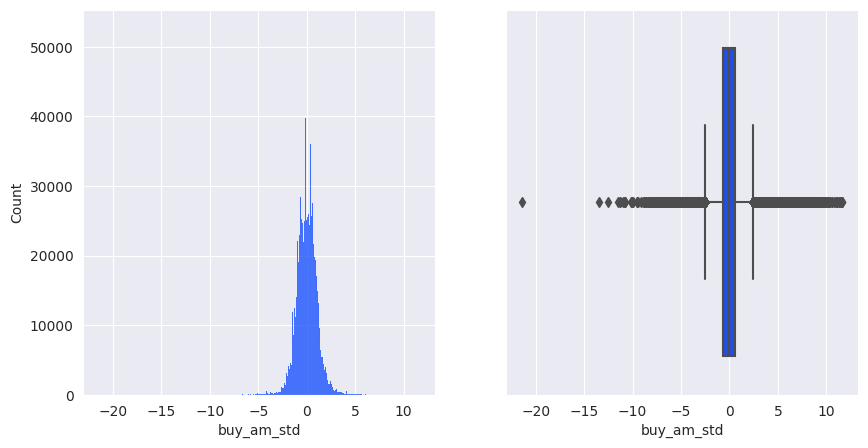

In [ ]:
interaction['buy_am_std'] = temp_price
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
sns.histplot(data = interaction, x = "buy_am_std", ax = axs[0])
sns.boxplot(data = interaction, x = "buy_am_std", ax = axs[1])
print(interaction['buy_am_std'].describe())

![image](https://user-images.githubusercontent.com/86637320/195536692-683811e9-566b-4ded-bac1-a6a3725a6c20.png)


- 3 sigma 분포 따르도록 세그먼트 분리

In [ ]:
bins = []
for i in [0.0015, 0.025, 0.16, 0.5, 0.84, 0.975, 0.9985]:
    bin = np.quantile(interaction.buy_am_std, i)
    print(f'{i*100}% : {bin}')
    bins.append(bin)

0.15% : -4.008353738145164
2.5% : -1.9070191404763317
16.0% : -0.9217668044639009
50.0% : -0.007832997542654055
84.0% : 0.9025150609847125
97.5% : 2.0181908914250495
99.85000000000001% : 3.9825871151723597


In [ ]:
interaction['pd_seg'] = 0

interaction.loc[interaction.buy_am_std < bins[0], "pd_seg"] = 0
interaction.loc[(interaction.buy_am_std >= bins[0]) & (interaction.buy_am_std < bins[1]), "pd_seg"] = 1
interaction.loc[(interaction.buy_am_std >= bins[1]) & (interaction.buy_am_std < bins[2]), "pd_seg"] = 2
interaction.loc[(interaction.buy_am_std >= bins[2]) & (interaction.buy_am_std < bins[3]), "pd_seg"] = 3
interaction.loc[(interaction.buy_am_std >= bins[3]) & (interaction.buy_am_std < bins[4]), "pd_seg"] = 4
interaction.loc[(interaction.buy_am_std >= bins[4]) & (interaction.buy_am_std < bins[5]), "pd_seg"] = 5
interaction.loc[(interaction.buy_am_std >= bins[5]) & (interaction.buy_am_std < bins[6]), "pd_seg"] = 6
interaction.loc[interaction.buy_am_std >= bins[6], "pd_seg"] = 7

##### 결과 해석
- `0 상품군` : 가격 평균이 매우 낮음 : 가격 편차가 큰 카테고리 내에서 이벤트로 구매한 경우, 소량 구매
- `7 상품군` : 구매 횟수 가장 많고, 평균 가격도 가장 높음 : 대량 구매, 고액 결제 

In [ ]:
interaction.groupby(["pd_seg"])[["buy_am_log", "buy_am", "buy_ct"]].agg(["mean", "median", "sum","size"])

buy_am_log                                           buy_am           \
             mean     median           sum     size           mean   median   
pd_seg                                                                        
0        5.210170   4.615121  3.817491e+04     7327     385.578136    100.0   
1        6.939358   6.908755  8.136051e+05   117245    1815.666724   1000.0   
2        7.535609   7.409136  5.068865e+06   672655    3306.281247   1650.0   
3        8.253148   8.095904  1.398402e+07  1694386    8210.099142   3280.0   
4        9.013550   8.850947  1.527152e+07  1694285   24105.872393   6980.0   
5        9.595923   9.210440  6.455590e+06   672743   70414.634037  10000.0   
6       10.207862   9.830971  1.195453e+06   117111  174170.355167  18600.0   
7       10.912199  10.714440  8.161234e+04     7479  431401.034898  45000.0   

                                 buy_ct                             
                 sum     size      mean median        sum     size  
pd_seg                                                              
0       2.825131e+06     7327  1.318411    1.0     9660.0     7327  
1       2.128778e+08   117245  1.384417    1.0   162316.0   117245  
2       2.223987e+09   672655  1.216201    1.0   818084.0   672655  
3       1.391108e+10  1694386  1.171555    1.0  1985066.0  1694386  
4       4.084222e+10  1694285  1.218742    1.0  2064897.0  1694285  
5       4.737095e+10   672743  1.470361    1.0   989175.0   672743  
6       2.039726e+10   117111  2.324274    1.0   272198.0   117111  
7       3.226448e+09     7479  5.582832    1.0    41754.0     7479

- `0 상품군`  : 66%가 100원딜
  - 가격 편차가 큰 카테고리에서 이벤트 참여한 경우

In [ ]:
for i in np.arange(0, 1, 0.01):
  print(f"{i *100}% : {np.quantile(interaction.loc[interaction.pd_seg == 0].buy_am, i)}")

0.0% : 1.0
1.0% : 17.0
2.0% : 40.0
3.0% : 50.0
4.0% : 50.0
5.0% : 90.0
6.0% : 100.0
7.000000000000001% : 100.0
8.0% : 100.0
9.0% : 100.0
10.0% : 100.0
11.0% : 100.0
12.0% : 100.0
13.0% : 100.0
14.000000000000002% : 100.0
15.0% : 100.0
16.0% : 100.0
17.0% : 100.0
18.0% : 100.0
19.0% : 100.0
20.0% : 100.0
21.0% : 100.0
22.0% : 100.0
23.0% : 100.0
24.0% : 100.0
25.0% : 100.0
26.0% : 100.0
27.0% : 100.0
28.000000000000004% : 100.0
28.999999999999996% : 100.0
30.0% : 100.0
31.0% : 100.0
32.0% : 100.0
33.0% : 100.0
34.0% : 100.0
35.0% : 100.0
36.0% : 100.0
37.0% : 100.0
38.0% : 100.0
39.0% : 100.0
40.0% : 100.0
41.0% : 100.0
42.0% : 100.0
43.0% : 100.0
44.0% : 100.0
45.0% : 100.0
46.0% : 100.0
47.0% : 100.0
48.0% : 100.0
49.0% : 100.0
50.0% : 100.0
51.0% : 100.0
52.0% : 100.0
53.0% : 100.0
54.0% : 100.0
55.00000000000001% : 100.0
56.00000000000001% : 100.0
57.00000000000001% : 100.0
57.99999999999999% : 100.0
59.0% : 100.0
60.0% : 100.0
61.0% : 100.0
62.0% : 100.0
63.0% : 100.0
64.0% : 100.0

#### 2) 성별/연령별 구매 가격 분포
  - 남, 녀 모두 연령대가 올라갈 수록 `0 ~ 3` 사이 제품보단 `4 ~ 7` 사이 제품을 사는 경향이 있다.

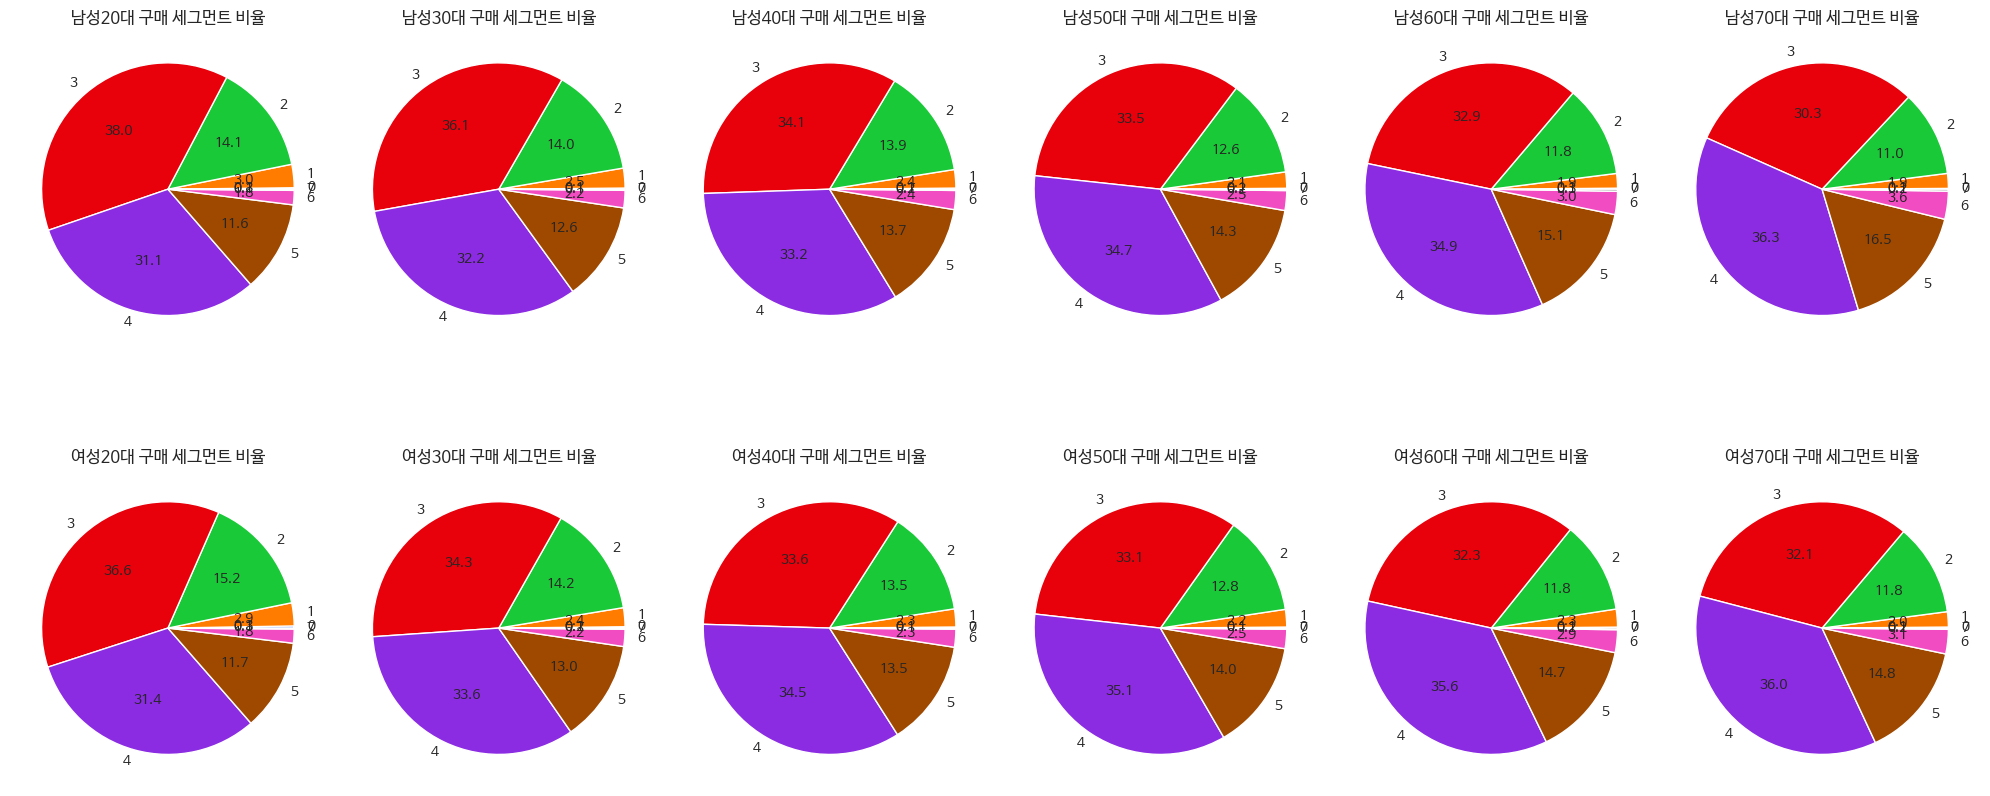

In [ ]:
temp = interaction.groupby(["ma_fem_dv_ages", "pd_seg"]).size().reset_index()
temp.rename(columns = {0 : "cnt"}, inplace = True)
name = temp.ma_fem_dv_ages.unique()

fig, axs = plt.subplots(2, 6, figsize = (20, 10))
for row in range(2):
  for col in range(6):
    ax = axs[row][col]
    temp_name = name[row * 6 + col]
    temp2 = temp.loc[temp.ma_fem_dv_ages == temp_name]

    pie_idx, pie_value = temp2["pd_seg"], temp2['cnt']
    ax.pie(pie_value, labels = pie_idx, autopct = "%.1f")
    ax.set_title(f"{temp_name} 구매 세그먼트 비율")

fig.tight_layout()

#### 3) 구매 금액별 성별/연령 분포
- 20대 여성의 경우 0 상품군의 구매 비율이 상대적으로 높음
  - 이벤트 활용 多

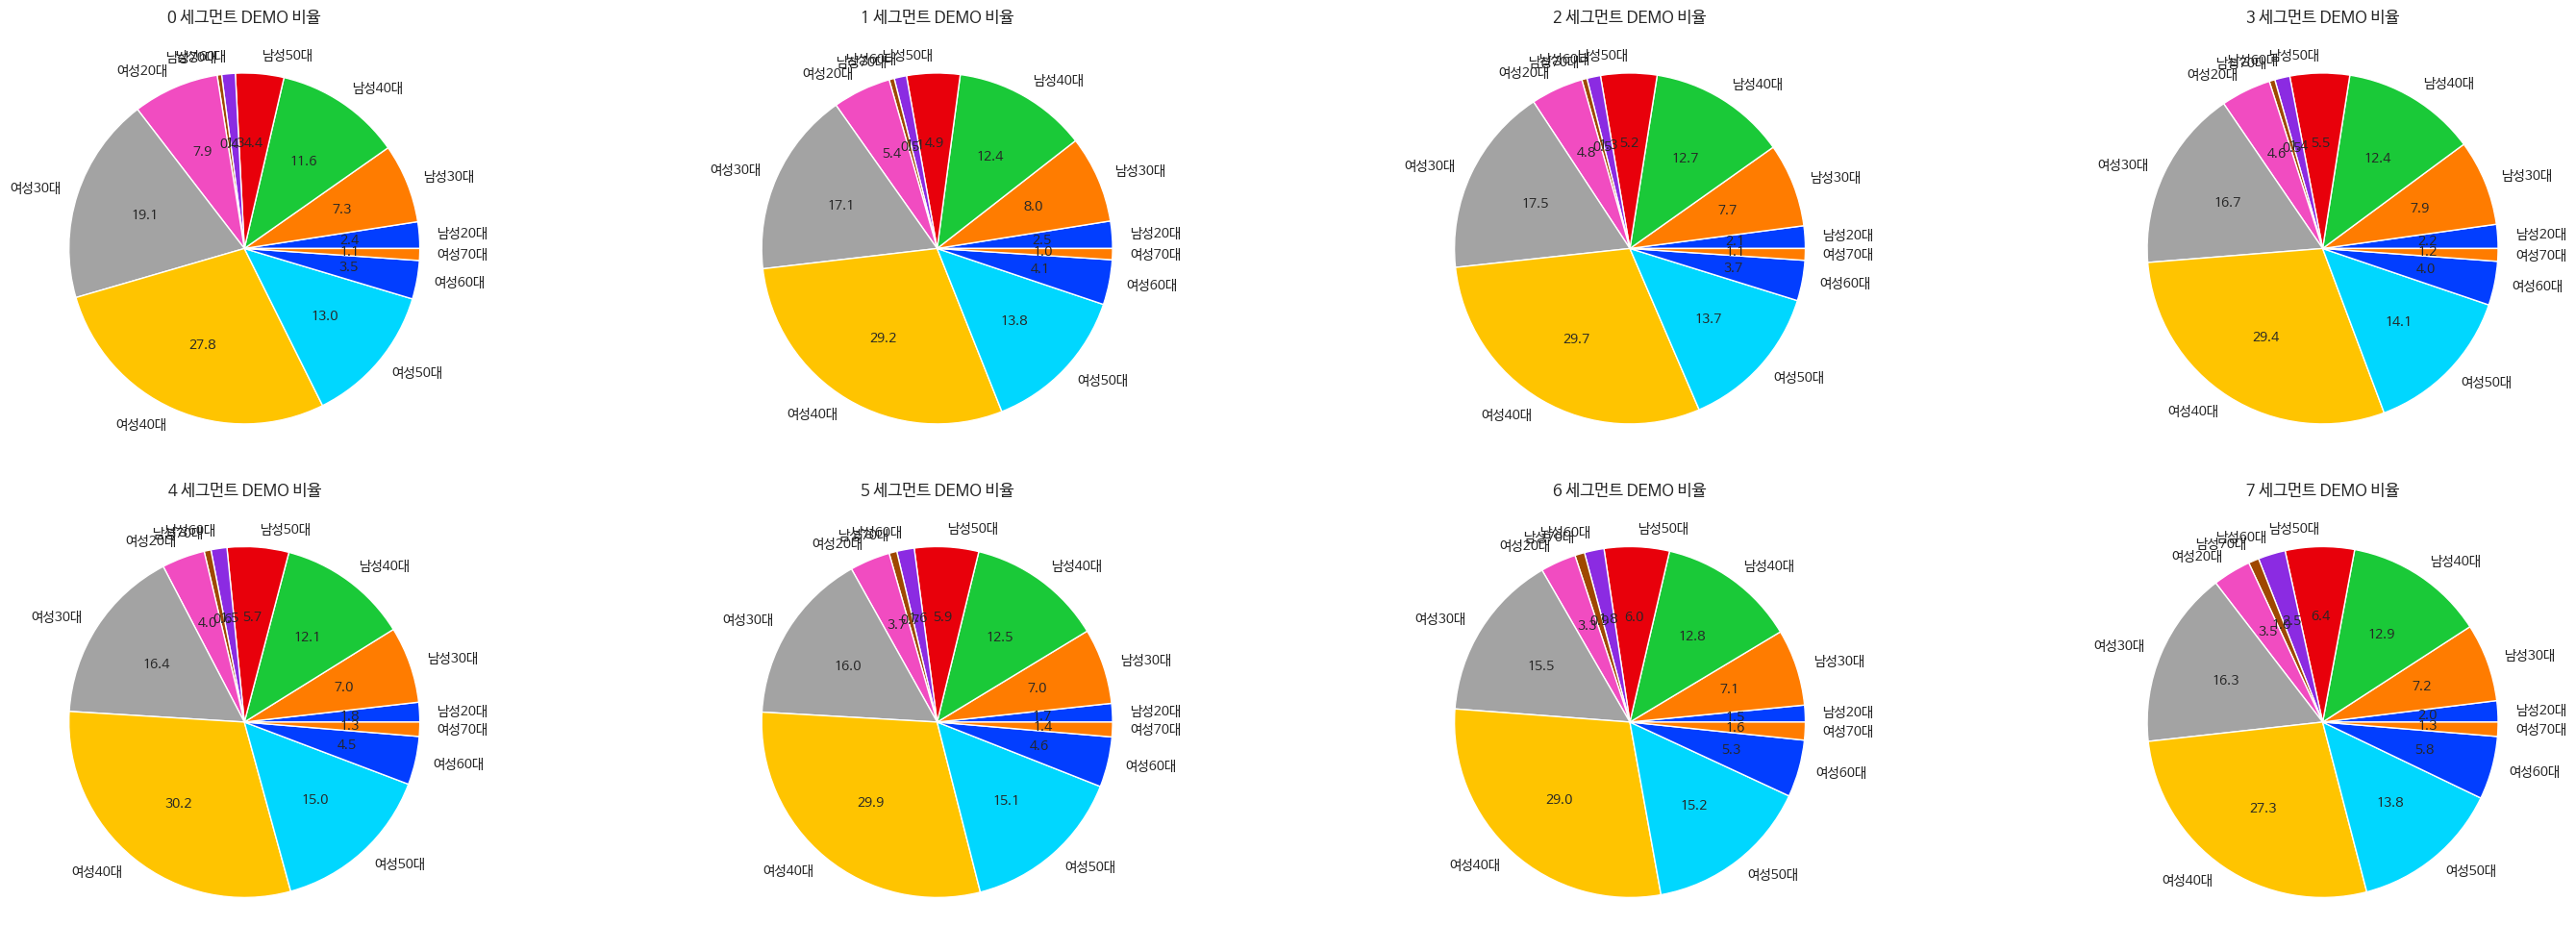

In [ ]:
temp = interaction.groupby(["pd_seg", "ma_fem_dv_ages"]).size().reset_index()
temp.rename(columns = {0 : "cnt"}, inplace = True)
name = temp.pd_seg.unique()

fig, axs = plt.subplots(2, 4, figsize = (30, 10))
for row in range(2):
  for col in range(4):
    ax = axs[row][col]
    temp_name = name[row * 4 + col]
    temp2 = temp.loc[temp.pd_seg == temp_name]

    pie_idx, pie_value = temp2["ma_fem_dv_ages"], temp2['cnt']
    ax.pie(pie_value, labels = pie_idx, autopct = "%.1f")
    ax.set_title(f"{temp_name} 세그먼트 DEMO 비율")

fig.tight_layout()

#### 4) 유통사 구매 비중 분포

- 백화점인 `A01`의 비율이 0에서 가장 높음
  - 100원 딜을 가장 `효율적`으로 사용한 곳이 바로 백화점
    - `효율적`? 평균 가격 대가 높은 카테고리에서 100원 딜 사용
- 백화점인 `A01`의 비율이 1 -> 7을 거치면서 점점 증가

- 편의점인 `A04`의 비율이 7에서 크게 증가한 이유? 
  - 담배, 종량제 봉투 등의 대량 구매

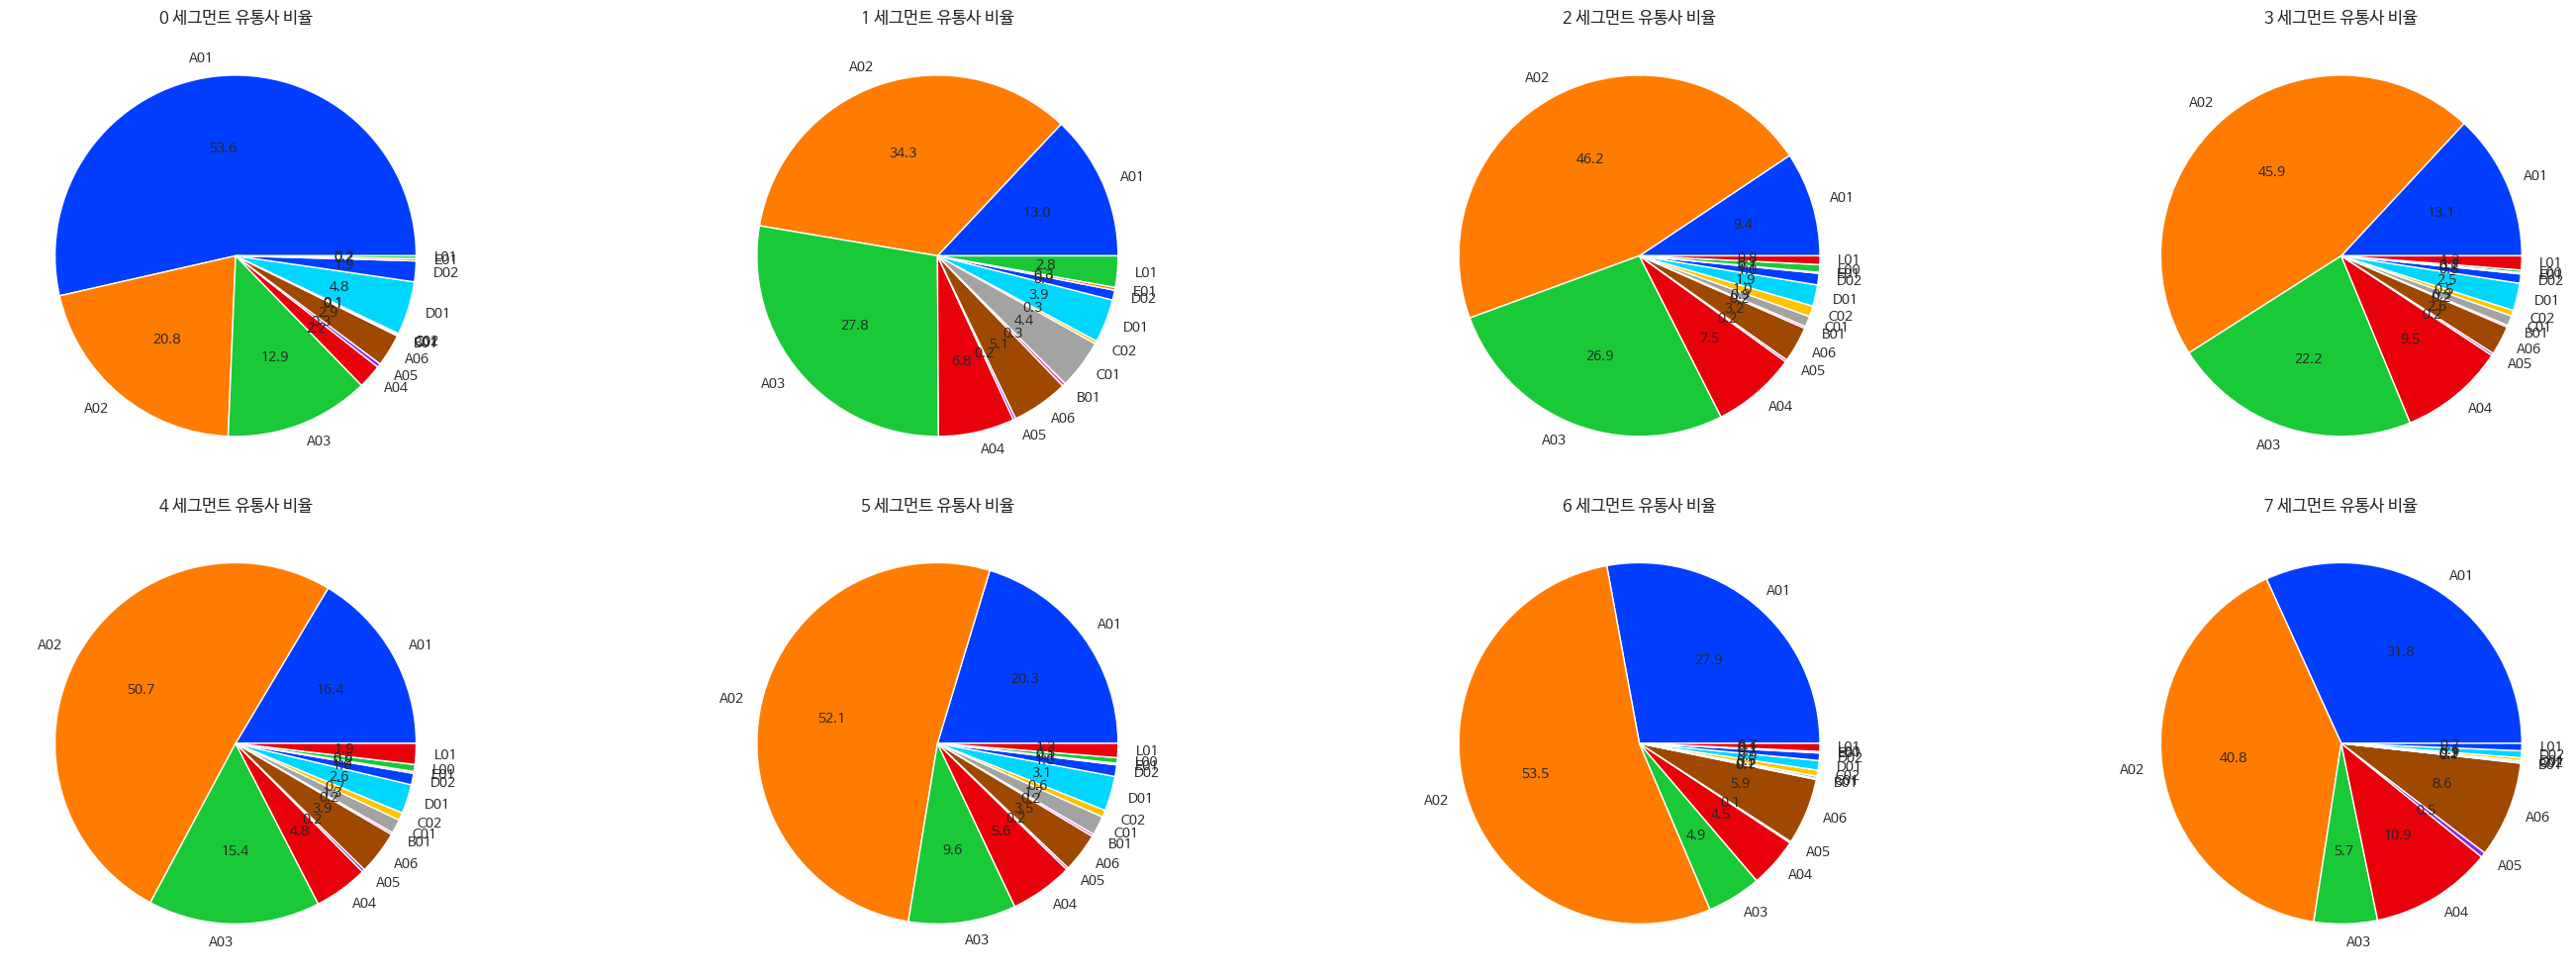

In [ ]:
temp = interaction.groupby(["pd_seg", "cop_c"]).size().reset_index()
temp.rename(columns = {0 : "cnt"}, inplace = True)
name = temp.pd_seg.unique()

fig, axs = plt.subplots(2, 4, figsize = (30, 10))
for row in range(2):
  for col in range(4):
    ax = axs[row][col]
    temp_name = name[row * 4 + col]
    temp2 = temp.loc[temp.pd_seg == temp_name]

    pie_idx, pie_value = temp2["cop_c"], temp2['cnt']
    ax.pie(pie_value, labels = pie_idx, autopct = "%.1f")
    ax.set_title(f"{temp_name} 세그먼트 유통사 비율")

fig.tight_layout()

#### 5) 판매량 기준 상위-하위 품목 확인
- `mean` : 평균 가격
- `size` : 판매 횟수 및 가격 종류 개수

##### 전체 상품

In [ ]:
temp = interaction.groupby(["clac_hlv_nm", "clac_mcls_nm", "pd_nm"])["buy_am"].agg(["mean", "size"]).reset_index()
temp.sort_values(by = ["size"], inplace = True)
temp[-20:][::-1]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1248,제휴사,F&B,D01,10348.280022,125333
233,과자,스낵류,일반스낵,3523.489000,95092
1167,유통사,A06,L07,57285.470954,93869
1496,청소/세탁/욕실용품,청소용품,종량제봉투,942.898266,88584
1158,유제품,우유,일반우유,4252.706871,80265
949,엘페이,비제휴사,L01,65905.528792,70939
402,대용식,봉지라면,국물봉지라면,3704.760449,61778
1252,제휴사,엔터테인먼트,C01,11616.868738,59644
227,과자,스낵류,감자스낵,2316.925678,56699
467,문구/사무용품,파티/팬시용품,기타파티/팬시용품,3486.361944,56412


In [ ]:
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
468,문구/사무용품,파티/팬시용품,불꽃놀이,3000.0,1
1060,원예/애완,동물병원,분양,800000.0,1
63,건강용품,건강가전,녹즙기/원액기,229000.0,1
1005,영상/음향가전,카메라/캠코더,기타광학기기,28580.0,1
611,세제/위생,화장지/티슈,냅킨,12000.0,1
1892,헬스/피트니스,피트니스,에어로빅복,59000.0,1
1244,자동차용품,자동차음향/가전기기,네비게이션,239000.0,1
542,생활/주방가전,이미용가전,제모기,13900.0,1
528,생활/렌탈서비스,생활서비스,핸드폰충전,3605000.0,1
523,생활/렌탈서비스,생활서비스,배달서비스,24900.0,1


##### 0 상품군
- 소량 구매 및 이벤트 구매

In [ ]:
def get_pd_seg(df, pd_seg):
  temp = df.loc[df.pd_seg == pd_seg]
  temp = temp.groupby(["clac_hlv_nm", "clac_mcls_nm", "pd_nm"])["buy_am"].agg(["mean", "size"]).reset_index()
  temp.sort_values(["size"], ascending = False,inplace = True)
  return temp

In [ ]:
temp = get_pd_seg(interaction, 0)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
55,기타(비상품),임대매출,임대매출,95.394990,519
386,테넌트/음식점,식당,베이커리,92.956879,487
198,여성의류,여성의류상의,여성티셔츠/탑,100.000000,456
261,제휴사,F&B,D01,190.714286,350
385,테넌트/음식점,식당,디저트,105.518868,212
387,테넌트/음식점,식당,분식,99.505495,182
201,여성의류,여성의류아우터,기타여성의류아우터,100.000000,170
254,유통사,A06,L07,211.739645,169
396,테넌트/음식점,푸드코트,푸드코트한식,127.329193,161
199,여성의류,여성의류세트,기타여성의류세트,99.533333,150


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
370,축산물,호주산소고기,호주산소양지,4000.0,1
371,축산물,호주산소고기,호주산소우둔,3000.0,1
90,냉장식품,포장반찬,김치류,100.0,1
353,축산물,닭고기류,닭안심,2000.0,1
87,냉장식품,어묵/맛살,김밥재료세트,100.0,1
350,축산물,국산소고기,한우앞다리,3488.0,1
210,영상/음향가전,TV,LED,300.0,1
346,축산물,국산돼지고기,국산돼지등심,1000.0,1
345,축산물,국산돼지고기,국산돼지갈비,2990.0,1
85,냉장식품,냉장간편식,냉장치킨족발류,1.0,1


##### 1 상품군

In [ ]:
temp = get_pd_seg(interaction, 1)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
865,제휴사,엔터테인먼트,C01,973.577236,5166
861,제휴사,F&B,D01,1203.856610,4561
811,유통사,A06,L07,2972.973011,3594
203,남성의류,남성의류세트,기타남성의류세트,100.069911,3576
651,엘페이,비제휴사,L01,347.752668,3279
139,과일,수입과일,바나나,1031.590440,2615
803,유제품,우유,일반우유,946.447431,2530
290,대용식,봉지라면,국물봉지라면,1028.340127,2355
272,냉장식품,햄/소시지,소시지,984.339161,2288
1001,채소,열매채소,고추,969.984436,2056


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
823,음료,음료세트,기능성음료세트,800.0,1
822,음료,음료세트,과채음료세트,1500.0,1
1186,컴퓨터,컴퓨터주변기기,공유기,10100.0,1
821,음료,생수,탄산수,300.0,1
189,구기/필드스포츠,농구,농구공,6900.0,1
818,음료,기능성음료,한방음료,100.0,1
751,유아동의류,남아의류아우터,남아패딩,2000.0,1
1191,컴퓨터,컴퓨터주변기기,저장장치,3330.0,1
814,음료,과채음료,어린이음료,300.0,1
192,구기/필드스포츠,축구,축구화,20700.0,1


##### 2 상품군

In [ ]:
temp = get_pd_seg(interaction, 2)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
224,과자,스낵류,일반스낵,956.136640,19394
1162,제휴사,F&B,D01,2747.808743,12810
1311,채소,두부/콩나물류,두부류,1128.013488,12752
218,과자,스낵류,감자스낵,1094.504911,12422
1085,유통사,A06,L07,9183.549040,11766
439,문구/사무용품,파티/팬시용품,기타파티/팬시용품,1000.144819,10634
1254,주류,맥주,국산맥주,1676.913662,10401
1258,주류,소주,일반소주,1276.339929,9855
388,대용식,용기라면,국물용기라면,766.631330,8254
1071,유제품,가공유,가공우유,995.044889,8198


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1606,패션잡화,기타지갑,동전지갑,20000.0,1
1607,패션잡화,기타지갑,여권/통장지갑,49000.0,1
540,서적/음반/악기,악기,악기부품/액세서리,3500.0,1
117,계절가전,냉방가전,기타냉방가전,29800.0,1
1611,패션잡화,남성가방,남성클러치백,60000.0,1
1612,패션잡화,남성지갑,남성머니클립,86400.0,1
1620,패션잡화,남성화,남성부츠,62300.0,1
591,속옷/양말/홈웨어,여성속옷,올인원,285000.0,1
1220,조미료,식용유류,즉석기름,4000.0,1
697,수산물,해초류,매생이,2580.0,1


##### 3 상품군
- 종량제봉투 : 일반적인 개수 만큼 구매한 경우 

In [ ]:
temp = get_pd_seg(interaction, 3)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1411,청소/세탁/욕실용품,청소용품,종량제봉투,511.507461,46774
1165,제휴사,F&B,D01,5628.446375,41548
224,과자,스낵류,일반스낵,1574.454711,37338
1079,유제품,우유,일반우유,2917.267111,33136
1088,유통사,A06,L07,22487.627458,25632
378,대용식,봉지라면,국물봉지라면,2933.389693,23131
387,대용식,용기라면,국물용기라면,1131.138080,21502
885,엘페이,비제휴사,L01,11182.458975,21304
1083,유통사,A01,L02,13249.855357,20879
1417,축산물,계란류,일반계란,6336.151270,20394


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
497,생활/주방가전,생활가전,연수기,30000.0,1
1513,출산/육아용품,유아발육용품,바운서/쏘서/보행기,57850.0,1
119,계절가전,냉방가전,냉풍기,42400.0,1
855,아웃도어/레저,자전거,기타자전거,27000.0,1
488,생활/렌탈서비스,생활서비스,사진인화서비스,70000.0,1
132,공구/안전용품,안전용품,금고,724000.0,1
484,생활/렌탈서비스,렌탈서비스,악기/교육렌탈,258000.0,1
148,과일,견과류,잣,25800.0,1
865,아웃도어/레저,캠핑,오토캠핑용품세트,21900.0,1
32,건강식품,건강진액,발효원액,10000.0,1


##### 4 상품군

In [ ]:
temp = get_pd_seg(interaction, 4)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1190,제휴사,F&B,D01,11327.928110,44095
1112,유통사,A06,L07,53362.307292,39591
902,엘페이,비제휴사,L01,37243.417079,31699
1103,유제품,우유,일반우유,4566.855902,27738
222,과자,스낵류,일반스낵,3072.863747,25460
1435,청소/세탁/욕실용품,청소용품,종량제봉투,763.815459,23908
384,대용식,봉지라면,국물봉지라면,3706.261360,23240
216,과자,스낵류,감자스낵,2487.150040,22414
1194,제휴사,엔터테인먼트,C01,12429.470323,21279
442,문구/사무용품,파티/팬시용품,기타파티/팬시용품,3771.077098,19339


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
263,구기/필드스포츠,테니스,테니스라켓,42800.0,1
578,세제/위생,화장지/티슈,냅킨,12000.0,1
771,스포츠패션,여성등산/아웃도어의류,여성등산스웨트셔츠/후드/집업,159000.0,1
1276,조미료,프리믹스,아이스크림믹스,3900.0,1
1312,주방잡화,조리도구,얼음/빙수용품,4900.0,1
507,생활/주방가전,생활가전,연수기,54000.0,1
508,생활/주방가전,생활가전,의류스타일러,200000.0,1
778,스포츠패션,여성스포츠화,여성스포츠화부속품,39000.0,1
1655,패션잡화,남성패션액세서리,행커치프,27000.0,1
604,속옷/양말/홈웨어,여성속옷,코르셋,20700.0,1


##### 5 상품군

In [ ]:
temp = get_pd_seg(interaction, 5)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1167,제휴사,F&B,D01,21614.376910,20944
1316,채소,두부/콩나물류,두부류,4909.887959,11826
1171,제휴사,엔터테인먼트,C01,26712.358573,11490
1092,유통사,A06,L07,127580.532449,11310
395,대용식,용기라면,국물용기라면,4268.075260,10590
889,엘페이,비제휴사,L01,150168.560047,8535
190,과일,수입과일,바나나,5262.652978,8377
1078,유제품,가공유,가공우유,5257.766248,8047
1083,유제품,우유,일반우유,6973.975329,7985
385,대용식,봉지라면,국물봉지라면,5881.487176,7915


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
844,아웃도어/레저,낚시,낚시용품,64000.0,1
1496,축산물,호주산소고기,호주산소채끝,40000.0,1
252,구기/필드스포츠,배드민턴,배드민턴복,10000.0,1
486,상품권,생활요금상품판매/충전,교통카드판매,5000.0,1
755,스포츠패션,여성골프의류,여성골프패딩,239000.0,1
829,식기/조리기구,밀폐/보관용기,항아리/쌀독류,99000.0,1
976,원예/애완,고양이용품,고양이건강용품,29000.0,1
822,식기/조리기구,밀폐/보관용기,과실주병,6610.0,1
980,원예/애완,고양이용품,고양이식기/급수,5600.0,1
981,원예/애완,고양이용품,고양이이동장,238400.0,1


##### 6 상품군

In [ ]:
temp = get_pd_seg(interaction, 6)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
178,과자,스낵류,일반스낵,2.230654e+04,4867
1147,청소/세탁/욕실용품,청소용품,종량제봉투,4.366902e+03,3635
845,유제품,우유,일반우유,1.424363e+04,2554
172,과자,스낵류,감자스낵,7.408708e+03,2146
849,유통사,A01,L02,1.610300e+06,1972
1152,축산물,계란류,일반계란,1.615147e+04,1868
854,유통사,A06,L07,5.971336e+05,1787
355,문구/사무용품,파티/팬시용품,기타파티/팬시용품,1.719841e+04,1577
303,대용식,봉지라면,국물봉지라면,1.058393e+04,1409
177,과자,스낵류,옥수수스낵,5.366171e+03,1371


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
451,속옷/양말/홈웨어,남성양말류,남성수면양말,20000.0,1
463,속옷/양말/홈웨어,여성속옷,여성임부속옷,283000.0,1
466,속옷/양말/홈웨어,여성양말류,니삭스/오버니삭스,15100.0,1
477,속옷/양말/홈웨어,유아동양말류,손싸개/발싸개,110000.0,1
478,속옷/양말/홈웨어,유아동양말류,아동니삭스/오버니삭스,59000.0,1
1099,채소,잎채소,갓,9870.0,1
1321,패션잡화,남성가방,남성서류가방,3515000.0,1
500,수산물,갑각류,홍게,53400.0,1
1079,채소,뿌리채소,알타리무,23600.0,1
508,수산물,냉동포장생선류,포장크랩류,32700.0,1


##### 7 상품군
- 대량 구매 및 고액 결제

In [ ]:
temp = get_pd_seg(interaction, 7)
temp[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
503,청소/세탁/욕실용품,청소용품,종량제봉투,1.664546e+04,897
144,담배,일반담배,국산담배,4.677543e+04,521
329,유제품,우유,일반우유,4.215020e+04,299
94,과자,스낵류,일반스낵,7.583234e+04,167
89,과자,스낵류,감자스낵,3.026378e+04,147
134,냉장식품,어묵/맛살,어묵,1.249875e+05,114
504,축산물,계란류,일반계란,3.739657e+04,112
160,대용식,봉지라면,국물봉지라면,3.749194e+04,108
123,냉장식품,냉장간편식,냉장간편떡볶이,2.379326e+04,95
333,유통사,A01,L02,1.105262e+07,95


In [ ]:
temp[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
291,식기/조리기구,조리기구,프라이팬,805300.0,1
297,양곡,잡곡,콩,169200.0,1
298,양곡,잡곡,현미,59200.0,1
302,여성의류,여성의류상의,여성스웨터/풀오버,6670800.0,1
338,음료,과채음료,과채혼합음료,136200.0,1
303,여성의류,여성의류세트,여성정장세트,2930000.0,1
304,여행/레저서비스,이용권/입장권,문화/공연입장권,5004000.0,1
305,영상/음향가전,TV,TV장식장/거치대,2000000.0,1
307,완구,교육완구,퍼즐,310000.0,1
308,완구,남아완구,무선조종,1540000.0,1


## D. 유저별 결제 금액 분포
  - 고객 지출성향 파악 가능

### 1) 결제 금액 중앙값 기준

<Axes: xlabel='buy_std', ylabel='Count'>

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


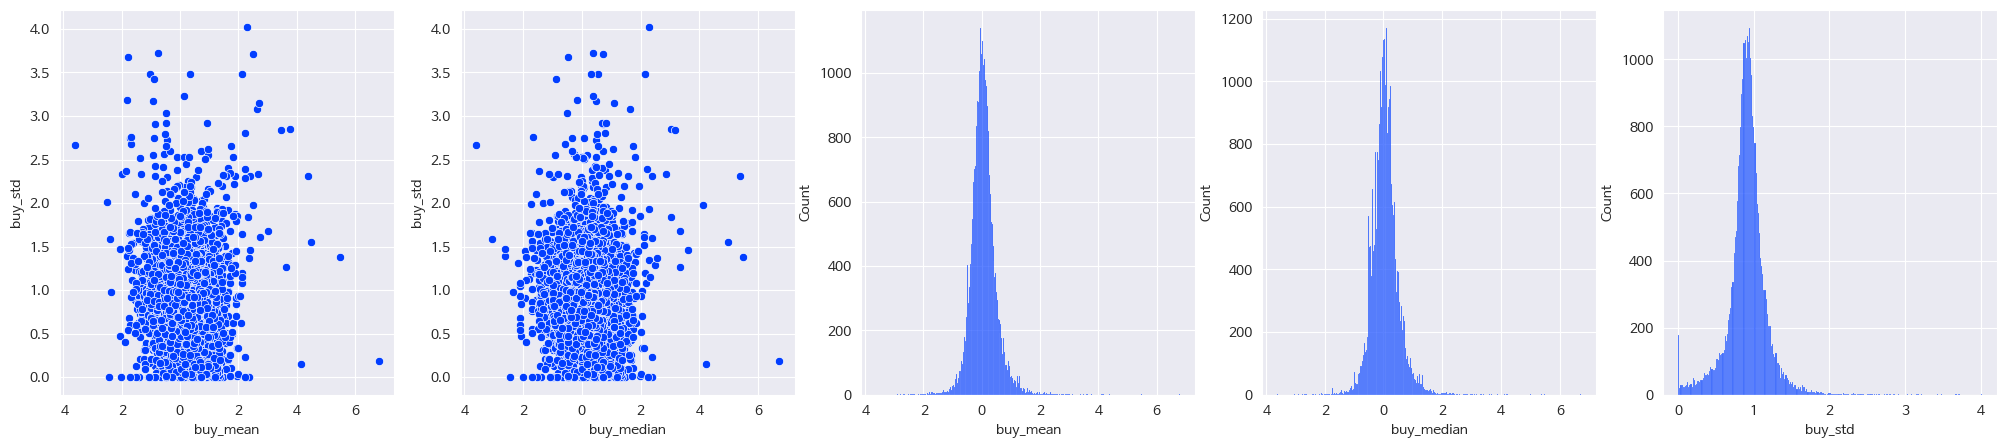

In [ ]:
temp = interaction.groupby(["cust"])["buy_am_std"].agg(["std", "mean", "median"]).reset_index()
temp.rename(columns = {"std" : "buy_std", "mean" : "buy_mean", "median" : "buy_median"}, inplace = True)
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
sns.scatterplot(data = temp, x = "buy_mean", y = "buy_std", ax = axs[0])
sns.scatterplot(data = temp, x = "buy_median", y = "buy_std", ax = axs[1])
sns.histplot(data = temp, x = "buy_mean", ax = axs[2])
sns.histplot(data = temp, x = "buy_median", ax = axs[3])
sns.histplot(data = temp, x = "buy_std", ax = axs[4])

- 중앙값 보다 많은 금액을 결제한 고객의 비율 : `54.81%`
- 중앙값 보다 적은 금액을 결제한 고객의 비율 : `45.19%`

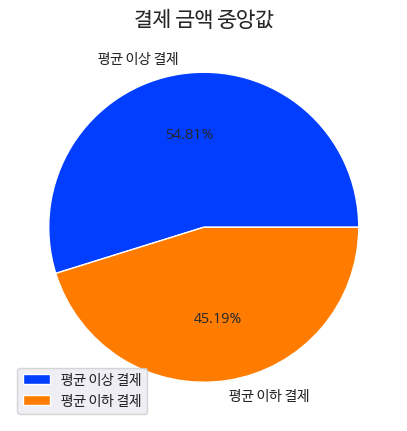

In [ ]:
labels = ["평균 이상 결제", "평균 이하 결제"]
cnt = len(temp.loc[temp.buy_median > 0]), len(temp.loc[temp.buy_median < 0])
fig, axs = plt.subplots(figsize =(5, 10))
axs.set_title("결제 금액 중앙값",fontsize=15)
axs.pie(x = cnt, labels = labels, autopct = '%.2f%%')
axs.legend()

![image](https://user-images.githubusercontent.com/86637320/195536692-683811e9-566b-4ded-bac1-a6a3725a6c20.png)


- 3 Sigma 분포 따르도록 세그먼트 분리

In [ ]:
bins = []
for i in [0.0015, 0.025, 0.16, 0.5, 0.84, 0.975, 0.9985]:
    bin = np.quantile(temp.buy_median, i)
    print(f'{i*100}% : {bin}')
    bins.append(bin)

0.15% : -1.7819158953668277
2.5% : -0.767026684433171
16.0% : -0.33871606629582
50.0% : 0.03633077247305532
84.0% : 0.4237680859713179
97.5% : 1.0578534781006927
99.85000000000001% : 2.366671634215814


In [ ]:
temp['cust_seg'] = 0
temp.loc[temp.buy_median < bins[0], "cust_seg"] = 0
temp.loc[(temp.buy_median >= bins[0]) & (temp.buy_median < bins[1]), "cust_seg"] = 1
temp.loc[(temp.buy_median >= bins[1]) & (temp.buy_median < bins[2]), "cust_seg"] = 2
temp.loc[(temp.buy_median >= bins[2]) & (temp.buy_median < bins[3]), "cust_seg"] = 3
temp.loc[(temp.buy_median >= bins[3]) & (temp.buy_median < bins[4]), "cust_seg"] = 4
temp.loc[(temp.buy_median >= bins[4]) & (temp.buy_median < bins[5]), "cust_seg"] = 5
temp.loc[(temp.buy_median >= bins[5]) & (temp.buy_median < bins[6]), "cust_seg"] = 6
temp.loc[temp.buy_median >= bins[6], "cust_seg"] = 7
temp = temp.merge(demo)

In [ ]:
temp.cust_seg.value_counts()

3    10157
4    10154
5     4036
2     4033
1      705
6      702
7       45
0       42
Name: cust_seg, dtype: int64

##### 결과 해석

- `7 세그먼트` : `buy_ct` 값이 크게 상승한 것으로 보아 대량 구매를 많이하는 고객

In [ ]:
temp = interaction.merge(temp[["cust", "cust_seg"]])
temp.groupby(["cust_seg"])["buy_am", "buy_ct"].agg(["mean", "sum", "median", "size"])

<ipython-input-68-c05b1526b8d5>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp.groupby(["cust_seg"])["buy_am", "buy_ct"].agg(["mean", "sum", "median", "size"])


buy_am                                     buy_ct             \
                   mean           sum   median     size       mean        sum   
cust_seg                                                                        
0           6330.891608  5.431905e+06   1000.0      858   1.020979      876.0   
1           6719.403901  3.761791e+08   1990.0    55984   1.232942    69025.0   
2           9094.102716  5.891005e+09   2950.0   647783   1.242498   804869.0   
3          15324.047962  3.101788e+10   3990.0  2024131   1.260532  2551481.0   
4          29781.580405  5.828440e+10   5960.0  1957062   1.285934  2516652.0   
5         102513.733707  2.953154e+10  10980.0   288074   1.320699   380459.0   
6         344585.923965  2.954824e+09  28000.0     8575   1.343324    11519.0   
7         165429.291885  1.263880e+08  86940.0      764  10.823298     8269.0   

                          
         median     size  
cust_seg                  
0           1.0      858  
1           1.0    55984  
2           1.0   647783  
3           1.0  2024131  
4           1.0  1957062  
5           1.0   288074  
6           1.0     8575  
7           1.0      764

### 2) 판매량 기준 상위-하위 품목 확인

In [ ]:
def get_cust_seg(df, user_info, cust_seg):
  temp = df.loc[df.cust.isin(user_info.loc[user_info.cust_seg == cust_seg].cust)]
  temp = temp.groupby(["clac_hlv_nm", "clac_mcls_nm", "pd_nm"])["buy_am"].agg(["mean", "size"]).reset_index()
  temp.sort_values(["size"], ascending = False,inplace = True)
  return temp

###### 0 세그먼트 : 중앙값 최소
- 지출 자체를 적게하는 경우, 소량 구매 후 거래가 없어 이상치로 잡힌 경우

In [ ]:
temp2 = get_cust_seg(interaction, temp, 0)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
39,엘페이,비제휴사,L01,6166.729614,233
57,제휴사,엔터테인먼트,C01,1795.089286,224
54,제휴사,F&B,D01,3262.222222,72
58,제휴사,엔터테인먼트,C02,4143.076923,65
26,상품권,모바일상품권,백화점/마트모바일상품권,23342.105263,38
38,엘페이,기타제휴사,L00,4074.900000,30
50,유통사,A04,L05,1874.090909,22
55,제휴사,F&B,D02,5506.666667,15
29,생활/렌탈서비스,생활서비스,기타생활서비스,500.000000,11
59,조리식품,냉장조리,도시락,4336.800000,10


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
42,여성의류,여성의류아우터,여성코트,269000.0,1
33,스포츠패션,남성스포츠화,남성런닝/트레이닝화,98000.0,1
30,생활/주방가전,이미용가전,고데기,35900.0,1
35,스포츠패션,남성일반스포츠의류,남성트레이닝복,49000.0,1
36,스포츠패션,여성골프의류,여성골프티셔츠/탑,23000.0,1
37,스포츠패션,여성일반스포츠의류,여성스포츠티셔츠/탑,24900.0,1
1,건강식품,홍삼/인삼가공식품,홍삼근,11000.0,1
40,여성의류,여성의류상의,여성남방셔츠,5500.0,1
41,여성의류,여성의류상의,여성티셔츠/탑,600.0,1
43,여성의류,여성의류아우터,여성패딩,359100.0,1


###### 1 세그먼트

In [ ]:
temp2 = get_cust_seg(interaction, temp, 1)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
500,엘페이,비제휴사,L01,8458.941891,3786
638,제휴사,F&B,D01,4638.856132,3392
642,제휴사,엔터테인먼트,C01,3753.522538,2995
721,주류,맥주,국산맥주,2239.491413,1514
725,주류,소주,일반소주,1770.140496,1210
148,과자,스낵류,일반스낵,1942.355046,1090
590,유통사,A04,L05,2394.976570,1067
583,유제품,우유,일반우유,2238.467710,1022
639,제휴사,F&B,D02,5380.997706,872
604,음료,생수,생수,917.685579,846


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
373,속옷/양말/홈웨어,여성속옷,여성내의,5900.0,1
366,속옷/양말/홈웨어,남성양말류,남성양말선물세트,11800.0,1
325,생활/주방가전,이미용가전,헤어세팅기,28900.0,1
793,채소,열매채소,건고추,19900.0,1
326,생활/주방가전,전화기,전화기,19900.0,1
826,청소/세탁/욕실용품,욕실용품,욕실화,5000.0,1
825,청소/세탁/욕실용품,욕실용품,욕실수납용품,3000.0,1
822,청소/세탁/욕실용품,욕실용품,변기시트/커버,16900.0,1
821,청소/세탁/욕실용품,욕실용품,목욕타올,4900.0,1
330,생활/주방가전,주방가전,인덕션/가스레인지,39900.0,1


###### 2 세그먼트

In [ ]:
temp2 = get_cust_seg(interaction, temp, 2)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1092,제휴사,F&B,D01,7448.652973,20252
1332,청소/세탁/욕실용품,청소용품,종량제봉투,643.507720,16840
209,과자,스낵류,일반스낵,2168.192962,15630
1184,주류,맥주,국산맥주,4045.473373,11154
1012,유제품,우유,일반우유,3144.301345,11150
366,대용식,용기라면,국물용기라면,1418.159114,9710
333,담배,일반담배,국산담배,5499.119128,9536
1019,유통사,A04,L05,5435.725585,8724
1096,제휴사,엔터테인먼트,C01,7251.525873,8677
203,과자,스낵류,감자스낵,1752.708864,8642


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
713,스포츠패션,여성등산/아웃도어의류,여성등산베스트,35000.0,1
708,스포츠패션,여성골프의류,여성골프전신/원피스,29000.0,1
627,수산물,어류,도미,6900.0,1
227,구기/필드스포츠,농구,기타농구용품,31500.0,1
629,수산물,어류,민어,7500.0,1
241,구기/필드스포츠,탁구,탁구라켓,7900.0,1
240,구기/필드스포츠,축구,축구용보호대,9500.0,1
635,수산물,어류,은어,19200.0,1
672,스포츠패션,남성골프의류,남성골프남방셔츠,119000.0,1
675,스포츠패션,남성골프의류,남성골프베스트,169000.0,1


###### 3 세그먼트

In [ ]:
temp2 = get_cust_seg(interaction, temp, 3)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1206,제휴사,F&B,D01,9247.577969,48641
228,과자,스낵류,일반스낵,2927.304079,40496
1452,청소/세탁/욕실용품,청소용품,종량제봉투,855.483098,40085
1126,유통사,A06,L07,46563.659340,38578
1117,유제품,우유,일반우유,3838.595060,34699
390,대용식,봉지라면,국물봉지라면,3559.941913,26340
451,문구/사무용품,파티/팬시용품,기타파티/팬시용품,3253.455667,25286
222,과자,스낵류,감자스낵,2153.925103,25208
1356,채소,두부/콩나물류,두부류,2588.457004,24107
1458,축산물,계란류,일반계란,7151.175536,22343


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
38,건강식품,꿀,로열제리,49000.0,1
1202,자동차용품,자동차음향/가전기기,네비게이션,239000.0,1
1677,패션잡화,남성패션액세서리,행커치프,27000.0,1
1837,헬스/피트니스,피트니스,러닝/워킹머신,160000.0,1
953,영상/음향가전,DVD/홈시어터,프로젝터,240000.0,1
498,생활/렌탈서비스,렌탈서비스,그림/인테리어렌탈,20000000.0,1
560,서적/음반/악기,악기,현악기,790000.0,1
883,아웃도어/레저,자전거,로드자전거,179000.0,1
1428,청소/세탁/욕실용품,욕실용품,목욕가운,13900.0,1
136,공구/안전용품,안전용품,금고,3272500.0,1


###### 4 세그먼트

In [ ]:
temp2 = get_cust_seg(interaction, temp, 4)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1212,제휴사,F&B,D01,11803.384690,41085
1132,유통사,A06,L07,61363.496543,40492
229,과자,스낵류,일반스낵,4231.204507,33593
921,엘페이,비제휴사,L01,85930.723425,32530
1123,유제품,우유,일반우유,4898.112898,29841
1460,청소/세탁/욕실용품,청소용품,종량제봉투,1167.713837,28655
394,대용식,봉지라면,국물봉지라면,3975.977949,24579
455,문구/사무용품,파티/팬시용품,기타파티/팬시용품,3747.197650,24169
1127,유통사,A01,L02,139895.518115,22827
1466,축산물,계란류,일반계란,7761.961223,21456


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1026,원예/애완,동물병원,분양,800000.0,1
1696,패션잡화,모자,군모,33600.0,1
1859,화장품/뷰티케어,메이크업,네일세트,12500.0,1
967,영상/음향가전,소형디지털가전,보이스레코더,139000.0,1
28,가구,침실가구,협탁,47900.0,1
333,냉장/세탁가전,냉장/냉동고,업소용냉장고,390000.0,1
838,시즌스포츠,스키/보드,스키/보드고글,95700.0,1
1021,원예/애완,기타애완동물,관상어,15000.0,1
23,가구,주방가구,주방수납장,420000.0,1
525,생활/주방가전,이미용가전,제모기,13900.0,1


###### 5 세그먼트

In [ ]:
temp2 = get_cust_seg(interaction, temp, 5)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
1081,제휴사,F&B,D01,15772.343736,10991
1011,유통사,A06,L07,105929.405303,6600
1085,제휴사,엔터테인먼트,C01,16560.520604,6164
1006,유통사,A01,L02,374444.459360,5155
818,엘페이,비제휴사,L01,100140.486233,4685
210,과자,스낵류,일반스낵,8975.283341,4214
1082,제휴사,F&B,D02,14128.037912,4062
249,남성의류,남성의류세트,기타남성의류세트,154304.931544,3652
1002,유제품,우유,일반우유,6411.901413,3469
1086,제휴사,엔터테인먼트,C02,28005.701961,2550


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
66,건강용품,일반의약외품,임신/배란테스트기,5000.0,1
1419,출산/육아용품,유아발육용품,아기띠/캐리어,99000.0,1
1250,채소,뿌리채소,알타리무,2490.0,1
463,생활/주방가전,이미용가전,고데기,54800.0,1
383,문구/사무용품,사무기기,제본기,116000.0,1
635,수산물,연체류,해삼,9960.0,1
1418,출산/육아용품,유아발육용품,붕붕카/스프링카/흔들말,21800.0,1
33,건강식품,영양제,글루코사민,58800.0,1
465,생활/주방가전,이미용가전,이발기,39900.0,1
1140,조미료,식용유류,즉석기름,49000.0,1


###### 6 세그먼트

In [ ]:
temp2 = get_cust_seg(interaction, temp, 6)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
450,제휴사,F&B,D01,2.422276e+04,894
454,제휴사,엔터테인먼트,C01,2.640783e+04,613
420,유통사,A06,L07,3.275425e+05,270
451,제휴사,F&B,D02,1.901864e+04,221
369,완구,교육완구,레고,1.506295e+05,217
415,유통사,A01,L02,1.468586e+06,179
342,엘페이,기타제휴사,L00,3.274468e+05,170
695,패션잡화,패션액세서리,기타패션잡화,2.331121e+06,141
418,유통사,A04,L05,2.204875e+04,120
168,담배,일반담배,국산담배,1.569153e+04,118


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
471,조리식품,온장조리,즉석어묵,2000.0,1
472,조리식품,온장조리,튀김류,6980.0,1
473,조리식품,즉석반찬,즉석국탕,11960.0,1
476,조미료,분말류,기타분말류,44800.0,1
499,조미료,조미료세트,기타조미료세트,3700.0,1
498,조미료,조미료류,액젓,8900.0,1
497,조미료,조미료류,액상조미료,32400.0,1
178,대용식,레토르트,즉석면류,12500.0,1
492,조미료,장류,쌈장,4980.0,1
490,조미료,장류,기타장류,21030.0,1


###### 7 세그먼트 : 중앙값 최대
  - 지출 자체가 많은 경우, 특정 상품을 대량 구매해 이상치로 잡힌 경우

In [ ]:
temp2 = get_cust_seg(interaction, temp, 7)
temp2[:20]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
63,유통사,A04,L05,1.010875e+05,205
69,음료,기능성음료,숙취해소음료,1.050000e+05,60
60,유제품,가공유,가공우유,1.433667e+05,42
62,유제품,우유,일반우유,4.742500e+04,40
61,유제품,요구르트,일반요구르트,3.871026e+04,39
33,담배,일반담배,국산담배,2.728378e+04,37
88,채소,열매채소,기타열매채소,9.660000e+04,29
15,과자,비스킷류,크래커,8.310435e+03,23
102,테넌트/음식점,식당,베이커리,1.944619e+05,21
53,엘페이,비제휴사,L01,3.255714e+06,19


In [ ]:
temp2[-20:]

,clac_hlv_nm,clac_mcls_nm,pd_nm,mean,size
4,건강식품,홍삼/인삼가공식품,홍삼정/분말/환,45900.0,1
31,냉장식품,냉장간편식,냉장드레싱,9800.0,1
40,세제/위생,화장지/티슈,롤티슈,159200.0,1
68,음료,기능성음료,비타민/에너지음료,5400.0,1
51,양곡,잡곡,현미,42000.0,1
66,음료,과채음료,과채혼합음료,136200.0,1
64,유통사,A05,L06,48400.0,1
56,완구,여아완구,역할놀이,700800.0,1
55,여성의류,여성의류아우터,여성패딩,237300.0,1
54,여성의류,여성의류아우터,여성재킷,178000.0,1


### 3) 성별/연령별 세그먼트 분포

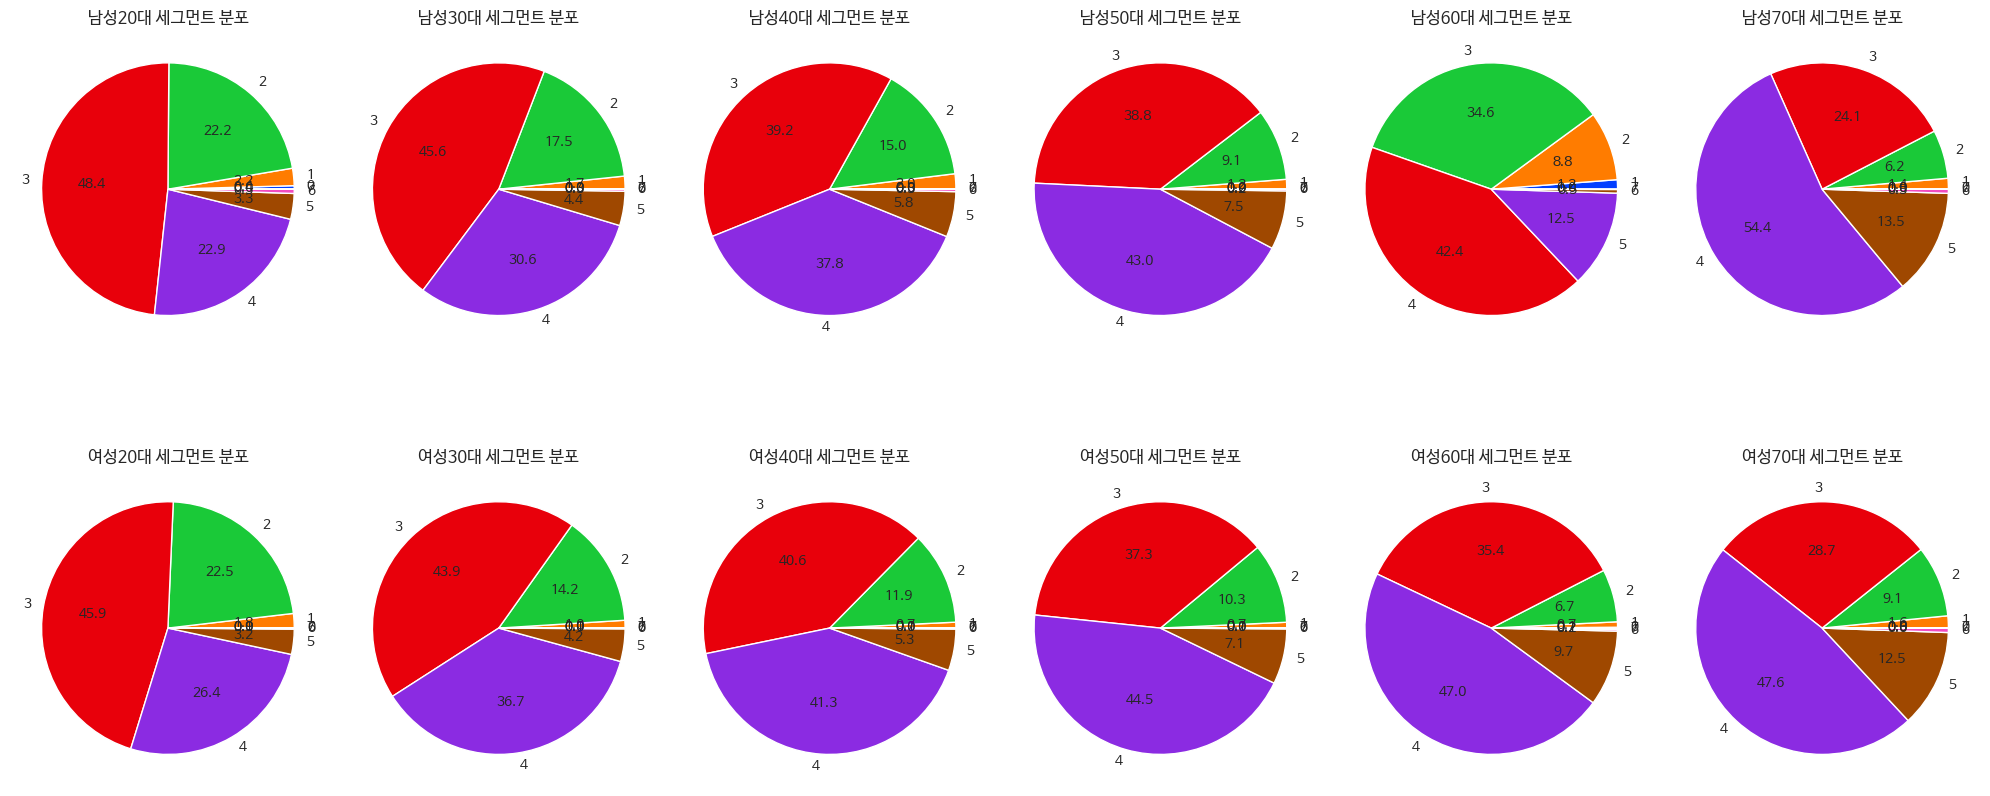

In [ ]:
temp2 = temp.groupby(["ma_fem_dv_ages", "cust_seg"]).size().reset_index()
temp2.rename(columns = {0 : "cnt"}, inplace = True)
name = temp2.ma_fem_dv_ages.unique()

fig, axs = plt.subplots(2, 6, figsize = (20, 10))
for row in range(2):
  for col in range(6):
    ax = axs[row][col]
    temp_name = name[row * 6 + col]
    temp3 = temp2.loc[temp2.ma_fem_dv_ages == temp_name]

    pie_idx, pie_value = temp3["cust_seg"], temp3['cnt']
    ax.pie(pie_value, labels = pie_idx, autopct = "%.1f")
    ax.set_title(f"{temp_name} 세그먼트 분포")

fig.tight_layout()

<Axes: xlabel='ma_fem_dv_ages', ylabel='count'>

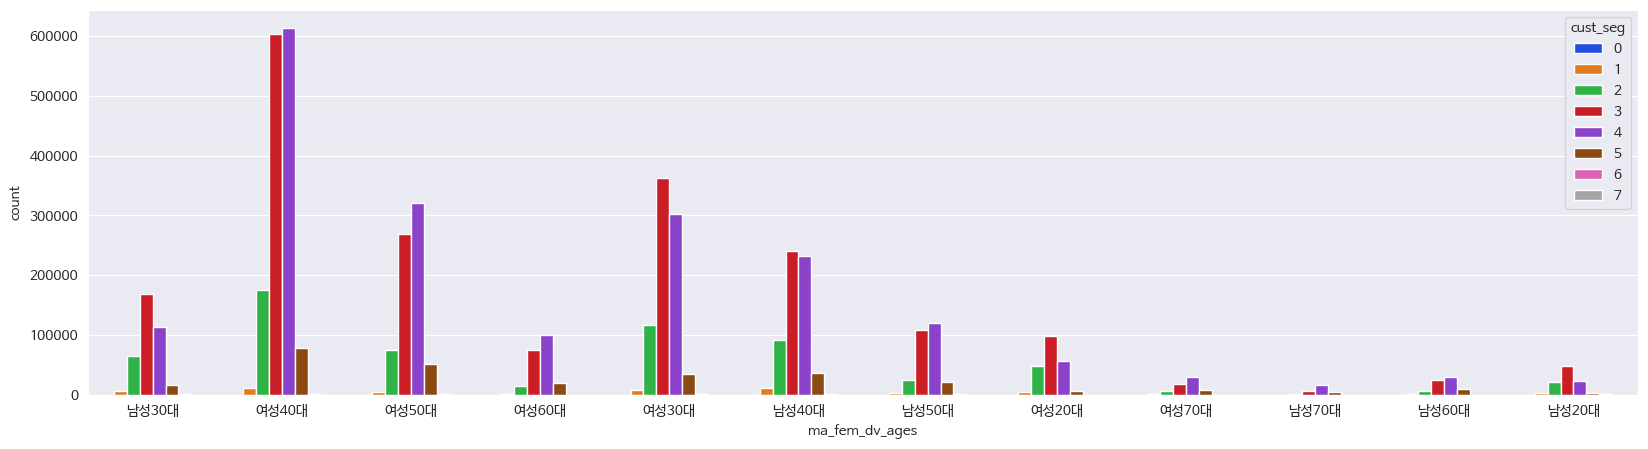

In [ ]:
fig, axs = plt.subplots(figsize=(20, 5))
sns.countplot(data = temp, x = "ma_fem_dv_ages", hue = "cust_seg")

### 4) 구매 금액별 성별/연령 분포

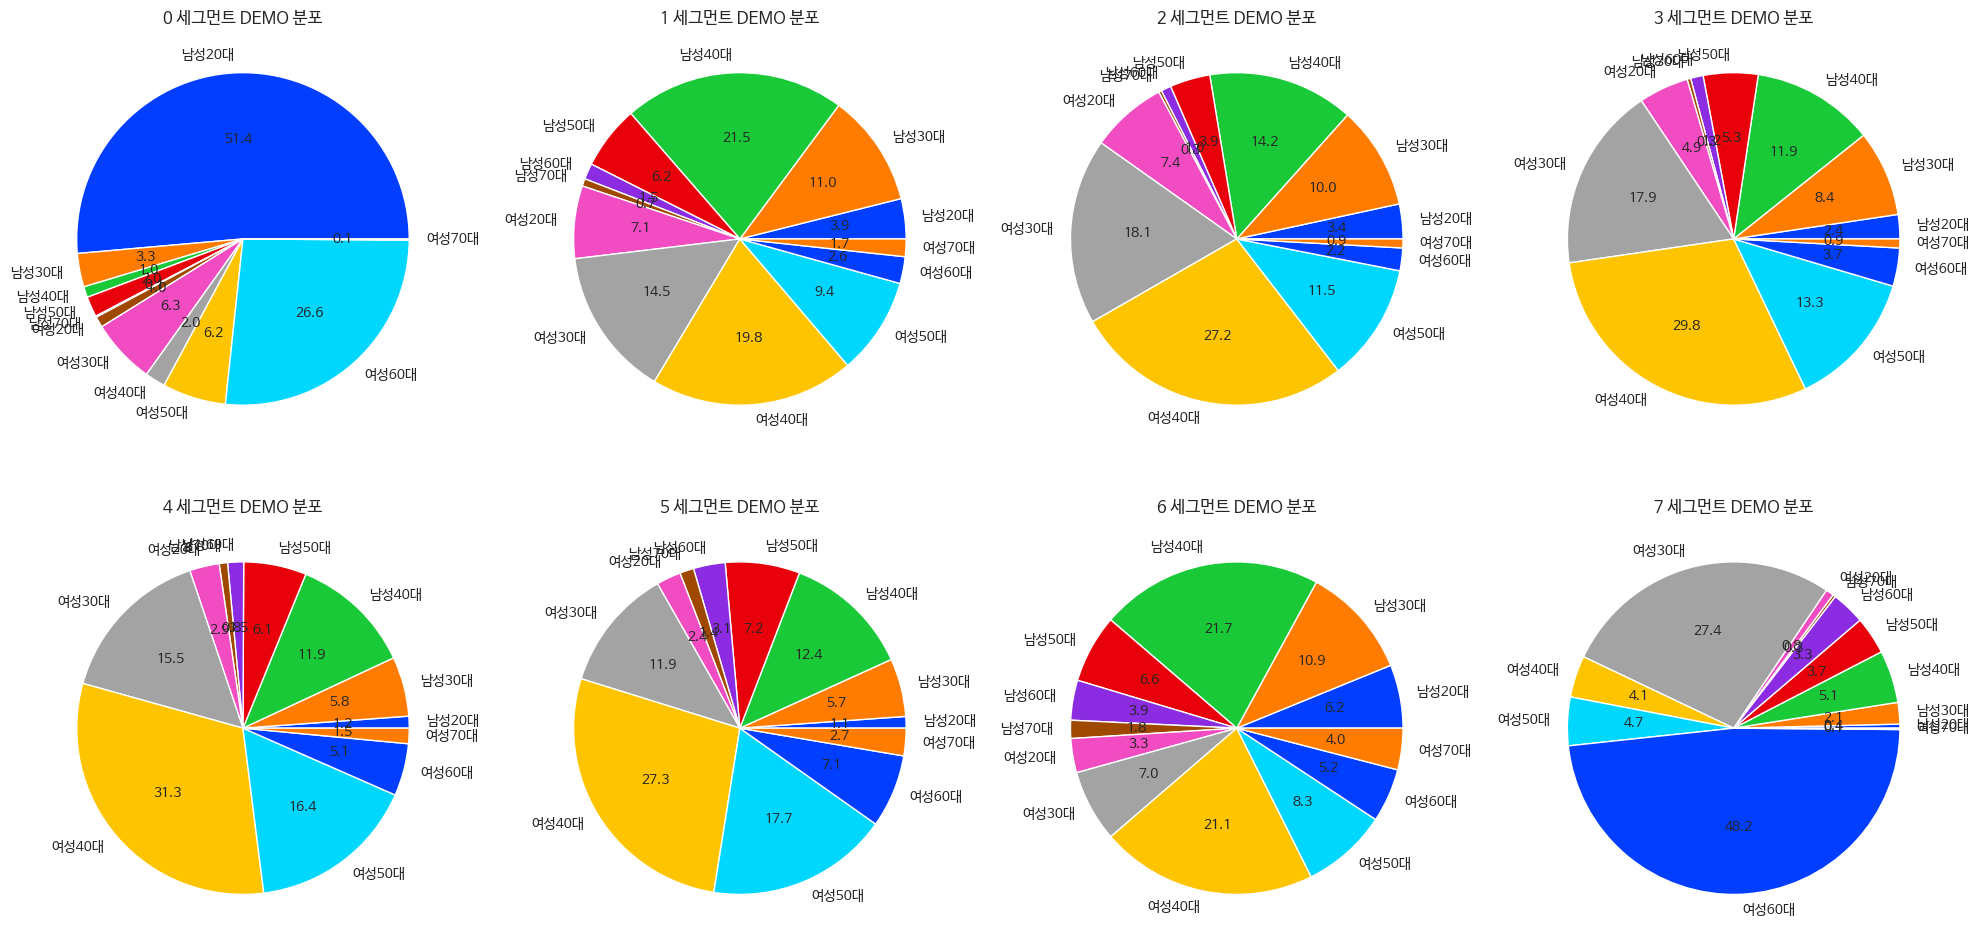

In [ ]:
temp2 = temp.groupby(["cust_seg", "ma_fem_dv_ages"]).size().reset_index()
temp2.rename(columns = {0 : "cnt"}, inplace = True)
name = temp2.cust_seg.unique()

fig, axs = plt.subplots(2, 4, figsize = (20, 10))
for row in range(2):
  for col in range(4):
    ax = axs[row][col]
    temp_name = name[row * 4 + col]
    temp3 = temp2.loc[temp2.cust_seg == temp_name]

    pie_idx, pie_value = temp3["ma_fem_dv_ages"], temp3['cnt']
    ax.pie(pie_value, labels = pie_idx, autopct = "%.1f")
    ax.set_title(f"{temp_name} 세그먼트 DEMO 분포")

fig.tight_layout()

<Axes: xlabel='cust_seg', ylabel='count'>

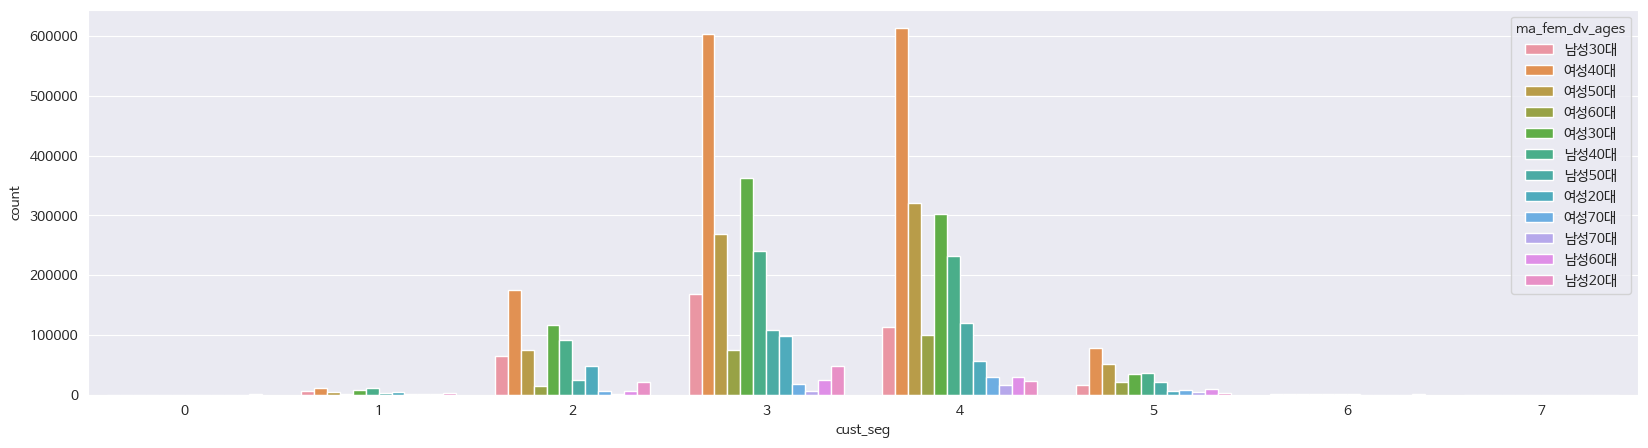

In [ ]:
fig, axs = plt.subplots(figsize=(20, 5))
sns.countplot(data = temp, x = "cust_seg", hue = "ma_fem_dv_ages")

### 5) 구매 금액별 거주지 분포

<Axes: xlabel='zon_hlv', ylabel='count'>

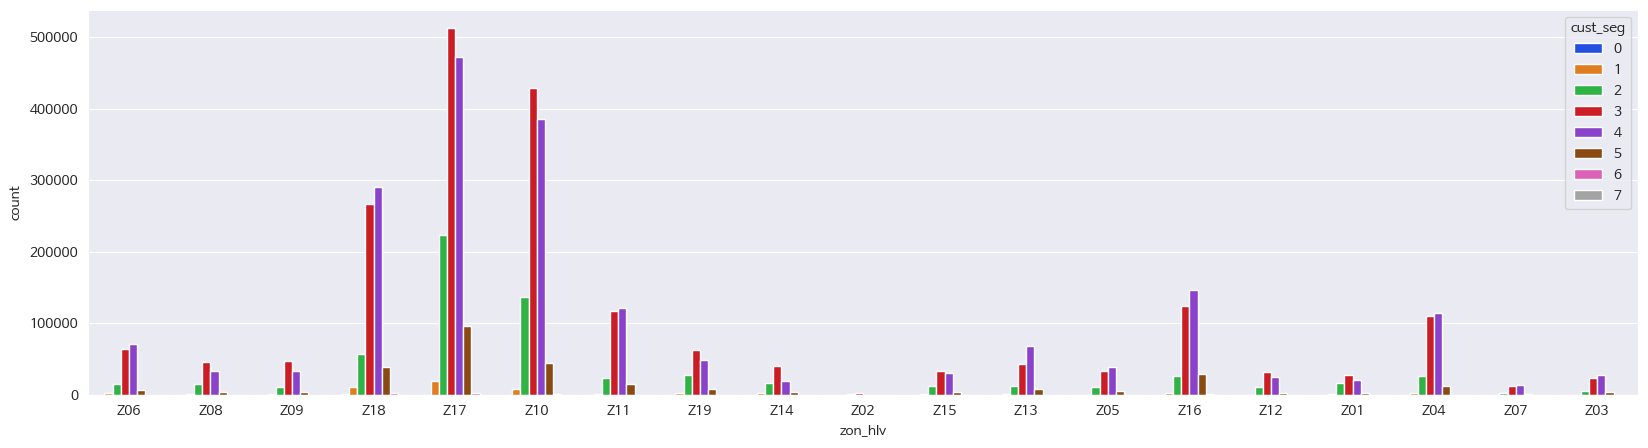

In [ ]:
fig, axs = plt.subplots(figsize=(20, 5))
sns.countplot(data = temp, x = "zon_hlv", hue = "cust_seg")

- `Z17(서울)`은 상위 세그먼트에서 높은 비율을 차지함 → 지출 성향이 큰 경우가 많음

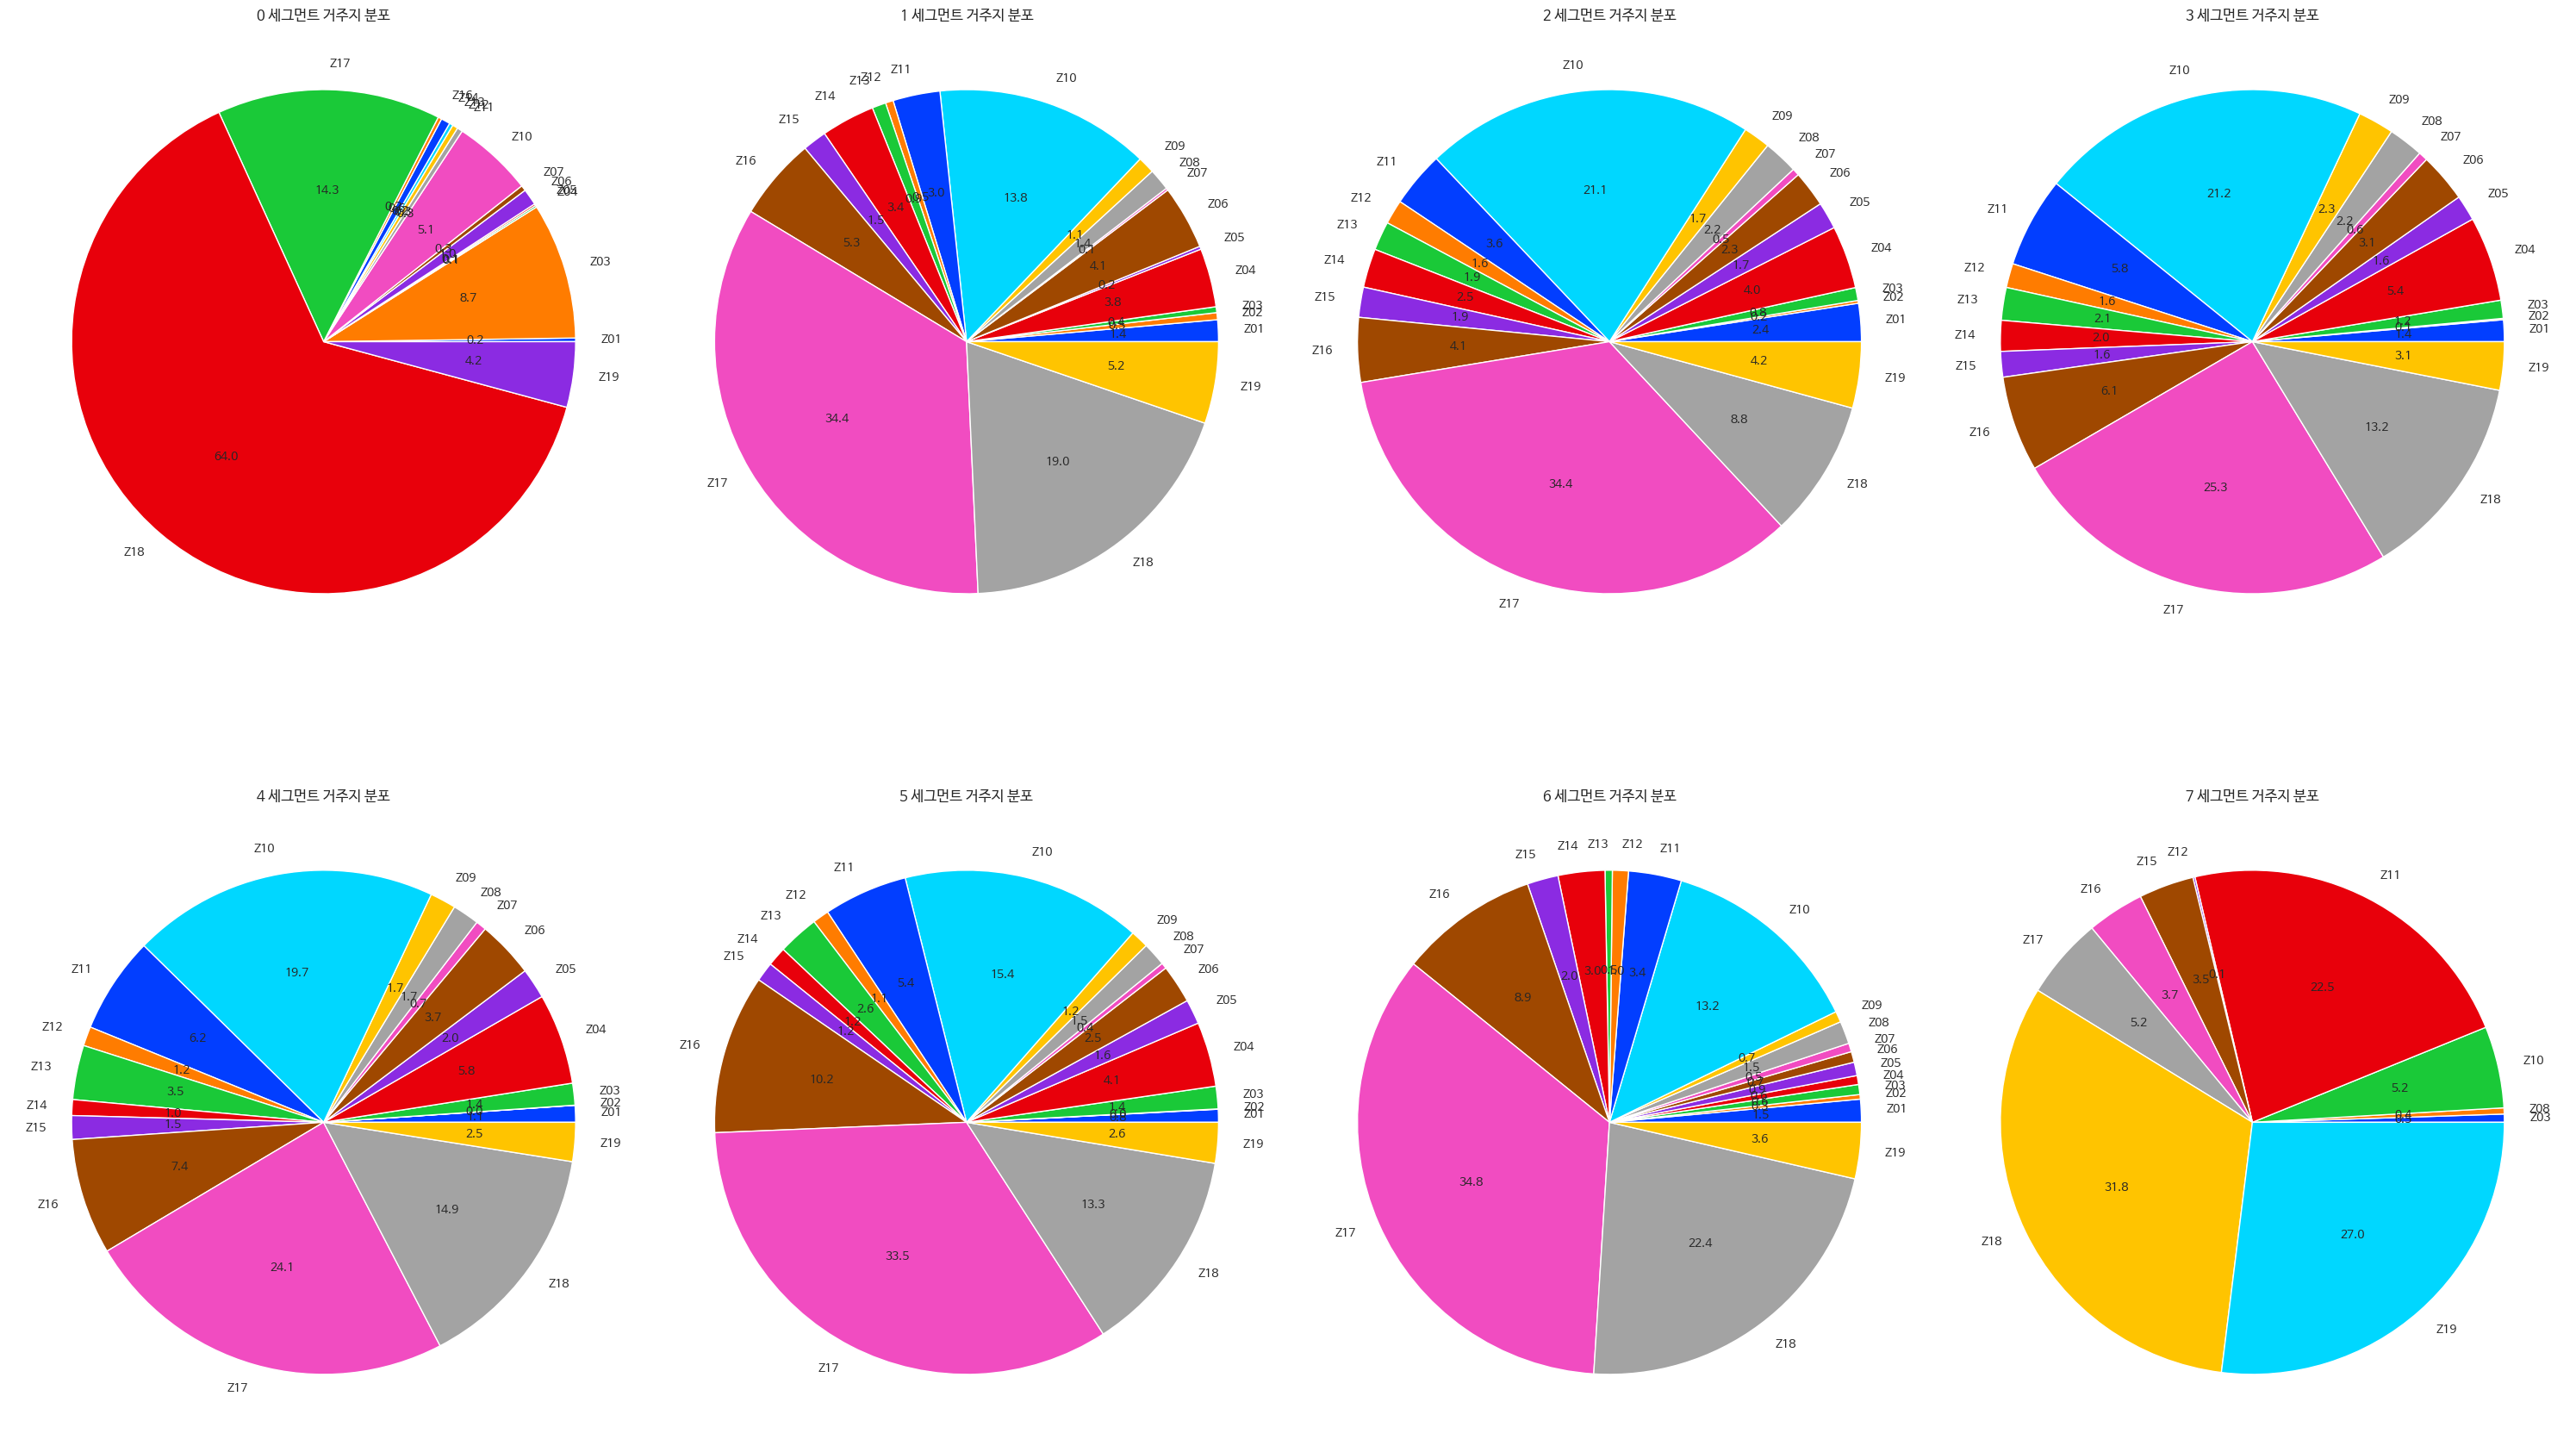

In [ ]:
temp2 = temp.groupby(["cust_seg", "zon_hlv"]).size().reset_index()
temp2.rename(columns = {0 : "cnt"}, inplace = True)
name = temp2.cust_seg.unique()

fig, axs = plt.subplots(2, 4, figsize = (30, 20))
for row in range(2):
  for col in range(4):
    ax = axs[row][col]
    temp_name = name[row * 4 + col]
    temp3 = temp2.loc[temp2.cust_seg == temp_name]

    pie_idx, pie_value = temp3["zon_hlv"], temp3['cnt']
    ax.pie(pie_value, labels = pie_idx, autopct = "%.1f")
    ax.set_title(f"{temp_name} 세그먼트 거주지 분포")

fig.tight_layout()